# **Préparation des données**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/M2/biomed/deep_seg/'

/content/drive/MyDrive/Colab Notebooks/M2/biomed/deep_seg


In [ ]:
%mkdir -p /content/seg_imgs/train
%cp -d -r '/content/drive/MyDrive/Colab Notebooks/M2/biomed/deep_seg/train/' '/content/seg_imgs/'
%cd /content/

/content


**Il faut vérifier que tous les inputs possédent un masque, sinon, nous supprimons ceux qui n'en ont pas**

In [ ]:
import os
import re

training_folder = '/content/seg_imgs/train/input/'
ground_truth_folder = '/content/seg_imgs/train/output/'

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return match.group(0) if match else None

ground_truth_numbers = {extract_number(f) for f in os.listdir(ground_truth_folder) if f.endswith('.tif')}

for training_file in os.listdir(training_folder):
    if training_file.endswith('.tif'):
        number = extract_number(training_file)

        if number not in ground_truth_numbers:
            file_path = os.path.join(training_folder, training_file)
            os.remove(file_path)
            print(f"Deleted {file_path}")

print("Deletion complete.")



Deletion complete.


# **Visualisation des données**

Text(0.5, 1.0, 'Ground truth')

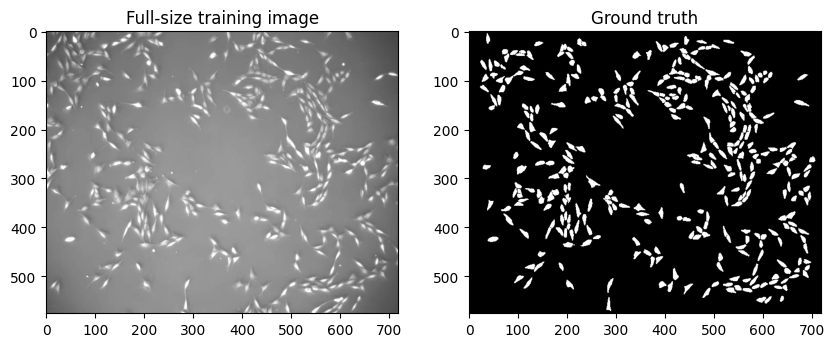

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt

train_img = Image.open(training_folder+'t230.tif')
train_mask = Image.open(ground_truth_folder+'man_seg230.tif')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( train_img, 'gray' )
plt.title( 'Full-size training image' )
plt.subplot(1, 2, 2)
plt.imshow( train_mask, 'gray' )
plt.title( 'Ground truth' )


In [ ]:
import random
import torch
from torchvision.transforms import functional as TF

class RandomCropTransform:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, image, mask):
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.output_size)
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        return image, mask


import torch

def threshold_image(image, threshold=0.5):
    return (image > threshold).float()


# **Création de la classe dataset et séparation de l'entrainement et de la validation (80%-20%)**

In [ ]:
def train_val_split(images_dir, masks_dir, val_ratio):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
    mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.tif')]

    total_size = len(image_files)
    val_size = int(total_size * val_ratio)

    indices = np.arange(total_size)
    np.random.shuffle(indices)

    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    train_image_files = [image_files[i] for i in train_indices]
    train_mask_files = [mask_files[i] for i in train_indices]

    val_image_files = [image_files[i] for i in val_indices]
    val_mask_files = [mask_files[i] for i in val_indices]

    return train_image_files, train_mask_files, val_image_files, val_mask_files


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class SegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_files, mask_files, transform=None):
        self.images_paths = sorted([os.path.join(images_dir, f) for f in image_files])
        self.masks_paths = sorted([os.path.join(masks_dir, f) for f in mask_files])
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.images_paths[idx]))
        mask = np.array(Image.open(self.masks_paths[idx]))
        # Apply transformations
        if self.transform:
            img, mask = self.transform(img, mask)
        img = transforms.ToTensor()(img).float()
        mask = transforms.ToTensor()(mask).float()
        return img, mask

images_dir = '/content/seg_imgs/train/input/'
masks_dir = '/content/seg_imgs/train/output/'

train_image_files, train_mask_files, val_image_files, val_mask_files = train_val_split(images_dir, masks_dir, 0.2)

seg_dataset = SegDataset(images_dir, masks_dir, train_image_files, train_mask_files)
seg_val_dataset = SegDataset(images_dir, masks_dir, val_image_files, val_mask_files)

seg_loader = DataLoader(seg_dataset, batch_size=8, shuffle=True)
seg_val_loader = DataLoader(seg_val_dataset, batch_size=8, shuffle=True)


# **Création du modèle UNET avec batch normalization, dropouts et une fonction d'activation Leaky ReLu** (Pas de sigmoid à la fin car on utilise la fonction BCElosswithlogits, les sigmoids sont faites dans les métriques)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(16)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout(0.1)

        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(32)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(32)
        self.drop2 = nn.Dropout(0.1)

        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(64)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(64)
        self.drop3 = nn.Dropout(0.2)

        self.conv4_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(128)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(128)
        self.drop4 = nn.Dropout(0.2)

        self.upconv5 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(64)
        self.conv5_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(64)
        self.drop5 = nn.Dropout(0.2)

        self.upconv6 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv6_1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn6_1 = nn.BatchNorm2d(32)
        self.conv6_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn6_2 = nn.BatchNorm2d(32)
        self.drop6 = nn.Dropout(0.1)

        self.upconv7 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv7_1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn7_1 = nn.BatchNorm2d(16)
        self.conv7_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn7_2 = nn.BatchNorm2d(16)
        self.drop7 = nn.Dropout(0.1)

        self.output_conv = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        c1 = F.leaky_relu(self.drop1(self.bn1_2(F.leaky_relu(self.bn1_1(self.conv1_1(x))))))
        p1 = F.avg_pool2d(c1, 2)

        c2 = F.leaky_relu(self.drop2(self.bn2_2(F.leaky_relu(self.bn2_1(self.conv2_1(p1))))))
        p2 = F.avg_pool2d(c2, 2)

        c3 = F.leaky_relu(self.drop3(self.bn3_2(F.leaky_relu(self.bn3_1(self.conv3_1(p2))))))
        p3 = F.avg_pool2d(c3, 2)

        c4 = F.leaky_relu(self.drop4(self.bn4_2(F.leaky_relu(self.bn4_1(self.conv4_1(p3))))))

        u5 = self.upconv5(c4)
        u5 = torch.cat((u5, c3), dim=1)
        c5 = F.leaky_relu(self.drop5(self.bn5_2(F.leaky_relu(self.bn5_1(self.conv5_1(u5))))))

        u6 = self.upconv6(c5)
        u6 = torch.cat((u6, c2), dim=1)
        c6 = F.leaky_relu(self.drop6(self.bn6_2(F.leaky_relu(self.bn6_1(self.conv6_1(u6))))))

        u7 = self.upconv7(c6)
        u7 = torch.cat((u7, c1), dim=1)
        c7 = F.leaky_relu(self.drop7(self.bn7_2(F.leaky_relu(self.bn7_1(self.conv7_1(u7))))))

        out = self.output_conv(c7)
        return out



#**Métriques : Accuracy et IoU**
**L'accuracy n'est pas très adaptée car la classe négative est largement prédominante dans le masque binaire**
(même une prédictoire totalement noire a une haute accuracy) Nous l'affichons tout de même car ça reste un repère supplémentaire.
#**L'IoU est la métrique principale à considérer.**

In [ ]:
def calculate_accuracy(preds, masks):
    preds = torch.sigmoid(preds)
    preds = preds > 0.92

    preds = preds.view(-1)
    masks = masks.view(-1)

    correct = (preds == masks).sum().item()
    total = masks.numel()
    accuracy = correct / total
    return accuracy

In [ ]:
def calculate_iou(preds, masks):
    preds = torch.sigmoid(preds) > 0.92

    preds = preds.view(preds.shape[0], -1)
    masks = masks.view(masks.shape[0], -1)

    intersection = torch.logical_and(preds, masks).sum(1)
    union = torch.logical_or(preds, masks).sum(1)

    iou_per_image = intersection / union.float()
    iou_per_image[union == 0] = 1
    batch_iou = iou_per_image.mean().item()

    return batch_iou


# **Entrainement du modèle sur 100 epochs avec une loss cross entropy binaire**
Il est nécessaire de mettre des poids pour avantager la classe positive car elle est trop minoritaire

#**Résultat final : training - IoU 0.6, validation - IoU 0.5 mais le modèle généralise bien mieux sur l'ensemble de test (Iou 0.77)**


Plot de la loss disponible en bas de l'output d'entrainement

Using device: cuda:0


100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch [1/100], Loss: 2.2356, Accuracy: 0.91, IoU: 0.14
Val_Loss: 2.6972, Val_Accuracy: 0.92, Val_IoU: 0.00


100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch [2/100], Loss: 1.6489, Accuracy: 0.91, IoU: 0.32
Val_Loss: 2.6743, Val_Accuracy: 0.92, Val_IoU: 0.00


100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


Epoch [3/100], Loss: 1.4472, Accuracy: 0.90, IoU: 0.39
Val_Loss: 2.5012, Val_Accuracy: 0.92, Val_IoU: 0.00


100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch [4/100], Loss: 1.2937, Accuracy: 0.90, IoU: 0.43
Val_Loss: 2.0363, Val_Accuracy: 0.92, Val_IoU: 0.02


100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch [5/100], Loss: 1.2000, Accuracy: 0.90, IoU: 0.49
Val_Loss: 1.6008, Val_Accuracy: 0.90, Val_IoU: 0.30


100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch [6/100], Loss: 1.1530, Accuracy: 0.90, IoU: 0.52
Val_Loss: 1.4056, Val_Accuracy: 0.90, Val_IoU: 0.44


100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Epoch [7/100], Loss: 1.1303, Accuracy: 0.89, IoU: 0.54
Val_Loss: 1.3911, Val_Accuracy: 0.89, Val_IoU: 0.46


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [8/100], Loss: 1.0929, Accuracy: 0.89, IoU: 0.56
Val_Loss: 1.3490, Val_Accuracy: 0.88, Val_IoU: 0.47


100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Epoch [9/100], Loss: 1.0764, Accuracy: 0.89, IoU: 0.58
Val_Loss: 1.3596, Val_Accuracy: 0.88, Val_IoU: 0.47


100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


Epoch [10/100], Loss: 1.0681, Accuracy: 0.89, IoU: 0.58
Val_Loss: 1.3810, Val_Accuracy: 0.88, Val_IoU: 0.48


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [11/100], Loss: 1.0715, Accuracy: 0.89, IoU: 0.59
Val_Loss: 1.3322, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [12/100], Loss: 1.0657, Accuracy: 0.89, IoU: 0.59
Val_Loss: 1.2943, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch [13/100], Loss: 1.0503, Accuracy: 0.89, IoU: 0.60
Val_Loss: 1.3527, Val_Accuracy: 0.88, Val_IoU: 0.48


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [14/100], Loss: 1.0428, Accuracy: 0.89, IoU: 0.60
Val_Loss: 1.2872, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [15/100], Loss: 1.0419, Accuracy: 0.89, IoU: 0.60
Val_Loss: 1.3377, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch [16/100], Loss: 1.0395, Accuracy: 0.89, IoU: 0.60
Val_Loss: 1.3022, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch [17/100], Loss: 1.0307, Accuracy: 0.89, IoU: 0.60
Val_Loss: 1.2828, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch [18/100], Loss: 1.0123, Accuracy: 0.89, IoU: 0.61
Val_Loss: 1.2707, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


Epoch [19/100], Loss: 0.9952, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.2562, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch [20/100], Loss: 1.0088, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.3086, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch [21/100], Loss: 1.0083, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.3530, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


Epoch [22/100], Loss: 1.0031, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.2883, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch [23/100], Loss: 0.9993, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.2974, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch [24/100], Loss: 0.9879, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.2524, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


Epoch [25/100], Loss: 0.9772, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.2725, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch [26/100], Loss: 0.9786, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.3668, Val_Accuracy: 0.88, Val_IoU: 0.48


100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch [27/100], Loss: 0.9819, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.2716, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch [28/100], Loss: 0.9717, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3189, Val_Accuracy: 0.89, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [29/100], Loss: 0.9737, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.3070, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch [30/100], Loss: 0.9645, Accuracy: 0.89, IoU: 0.62
Val_Loss: 1.3118, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch [31/100], Loss: 0.9445, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3596, Val_Accuracy: 0.88, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [32/100], Loss: 0.9537, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3350, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch [33/100], Loss: 0.9478, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3115, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Epoch [34/100], Loss: 0.9502, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2453, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch [35/100], Loss: 0.9253, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2836, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Epoch [36/100], Loss: 0.9267, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2721, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  3.01it/s]


Epoch [37/100], Loss: 0.9352, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2273, Val_Accuracy: 0.89, Val_IoU: 0.53


100%|██████████| 11/11 [00:03<00:00,  3.00it/s]


Epoch [38/100], Loss: 0.9111, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3118, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch [39/100], Loss: 0.9172, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2419, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch [40/100], Loss: 0.9247, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2654, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [41/100], Loss: 0.9025, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3056, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch [42/100], Loss: 0.9143, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.2860, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [43/100], Loss: 0.9165, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3036, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [44/100], Loss: 0.8933, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.2854, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch [45/100], Loss: 0.9132, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.2795, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Epoch [46/100], Loss: 0.9082, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2902, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch [47/100], Loss: 0.8855, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3181, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch [48/100], Loss: 0.8940, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3118, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch [49/100], Loss: 0.8847, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2978, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [50/100], Loss: 0.8696, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3678, Val_Accuracy: 0.89, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [51/100], Loss: 0.8651, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3464, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


Epoch [52/100], Loss: 0.8610, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3744, Val_Accuracy: 0.88, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [53/100], Loss: 0.8830, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.2858, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [54/100], Loss: 0.8789, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.4443, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


Epoch [55/100], Loss: 0.8709, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3059, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [56/100], Loss: 0.8601, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.4029, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Epoch [57/100], Loss: 0.8652, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3652, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


Epoch [58/100], Loss: 0.8537, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3508, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [59/100], Loss: 0.8485, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3446, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [60/100], Loss: 0.8455, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3511, Val_Accuracy: 0.88, Val_IoU: 0.50


100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch [61/100], Loss: 0.8589, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3297, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [62/100], Loss: 0.8320, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.3443, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [63/100], Loss: 0.8289, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4079, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch [64/100], Loss: 0.8455, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.3388, Val_Accuracy: 0.88, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [65/100], Loss: 0.8401, Accuracy: 0.89, IoU: 0.63
Val_Loss: 1.3350, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [66/100], Loss: 0.8439, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3868, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch [67/100], Loss: 0.8444, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.5208, Val_Accuracy: 0.88, Val_IoU: 0.48


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [68/100], Loss: 0.8417, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.5004, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [69/100], Loss: 0.8161, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4127, Val_Accuracy: 0.88, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch [70/100], Loss: 0.8302, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.3611, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [71/100], Loss: 0.8047, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4577, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [72/100], Loss: 0.8234, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3382, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


Epoch [73/100], Loss: 0.8165, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.4047, Val_Accuracy: 0.88, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch [74/100], Loss: 0.8246, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4430, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [75/100], Loss: 0.8001, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4236, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


Epoch [76/100], Loss: 0.8034, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3344, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch [77/100], Loss: 0.7976, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4181, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [78/100], Loss: 0.7992, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.3717, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch [79/100], Loss: 0.8033, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.3166, Val_Accuracy: 0.89, Val_IoU: 0.53


100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch [80/100], Loss: 0.8109, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.5221, Val_Accuracy: 0.89, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


Epoch [81/100], Loss: 0.8088, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4899, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [82/100], Loss: 0.7876, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.3367, Val_Accuracy: 0.89, Val_IoU: 0.53


100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch [83/100], Loss: 0.7966, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4066, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [84/100], Loss: 0.7989, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.4614, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [85/100], Loss: 0.7807, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.4754, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


Epoch [86/100], Loss: 0.7718, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.4824, Val_Accuracy: 0.88, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [87/100], Loss: 0.7934, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.3686, Val_Accuracy: 0.89, Val_IoU: 0.53


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [88/100], Loss: 0.7689, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.4918, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch [89/100], Loss: 0.7887, Accuracy: 0.89, IoU: 0.64
Val_Loss: 1.4046, Val_Accuracy: 0.88, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch [90/100], Loss: 0.7888, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.5740, Val_Accuracy: 0.89, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [91/100], Loss: 0.7708, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4562, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch [92/100], Loss: 0.7857, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.4240, Val_Accuracy: 0.89, Val_IoU: 0.52


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [93/100], Loss: 0.7645, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4404, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [94/100], Loss: 0.7789, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.4187, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch [95/100], Loss: 0.7732, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.4950, Val_Accuracy: 0.88, Val_IoU: 0.49


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [96/100], Loss: 0.7598, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4414, Val_Accuracy: 0.89, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.98it/s]


Epoch [97/100], Loss: 0.7598, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4272, Val_Accuracy: 0.88, Val_IoU: 0.50


100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch [98/100], Loss: 0.7600, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4743, Val_Accuracy: 0.88, Val_IoU: 0.51


100%|██████████| 11/11 [00:03<00:00,  2.95it/s]


Epoch [99/100], Loss: 0.7504, Accuracy: 0.89, IoU: 0.66
Val_Loss: 1.3164, Val_Accuracy: 0.89, Val_IoU: 0.53


100%|██████████| 11/11 [00:03<00:00,  2.97it/s]


Epoch [100/100], Loss: 0.7671, Accuracy: 0.89, IoU: 0.65
Val_Loss: 1.4701, Val_Accuracy: 0.88, Val_IoU: 0.50


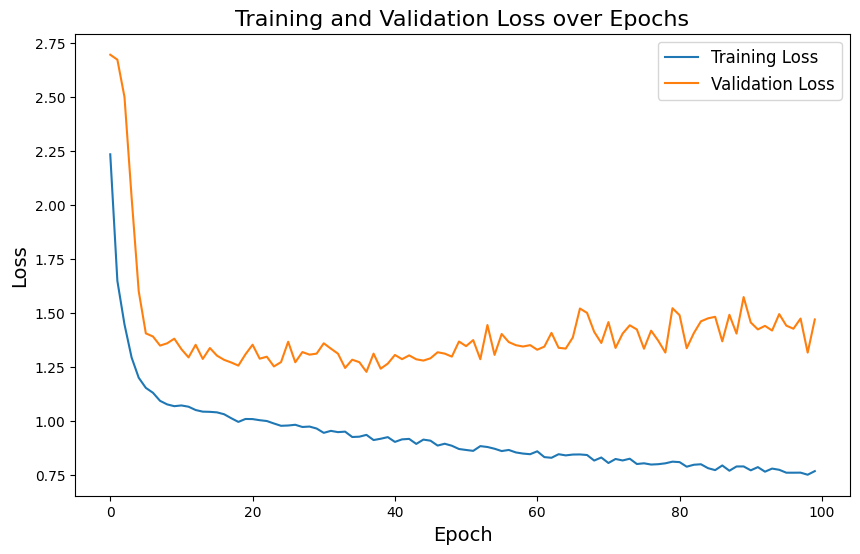

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_epochs = 100
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
class_weights = torch.tensor([10000], device=device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[0])

train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0

    total_accuracy = 0
    total_iou = 0

    model.train()
    for index, (images, masks) in enumerate(tqdm(seg_loader)):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, masks)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(preds, masks)
        total_accuracy += acc

        iou = calculate_iou(preds, masks)
        total_iou += iou

    avg_train_loss = total_train_loss / len(seg_loader)
    train_losses.append(avg_train_loss)

    epoch_accuracy = total_accuracy / len(seg_loader)
    epoch_iou = total_iou / len(seg_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {epoch_accuracy:.2f}, IoU: {epoch_iou:.2f}')

    total_iou = 0
    total_accuracy = 0
    model.eval()
    for index, (images, masks) in enumerate(seg_val_loader):
        with torch.no_grad():
          images = images.to(device)
          masks = masks.to(device)

          preds = model(images)
          loss = criterion(preds, masks)
          total_val_loss += loss.item()

          acc = calculate_accuracy(preds, masks)
          total_accuracy += acc

          iou = calculate_iou(preds, masks)
          total_iou += iou

    avg_val_loss = total_val_loss / len(seg_val_loader)
    epoch_accuracy = total_accuracy / len(seg_val_loader)
    epoch_iou = total_iou / len(seg_val_loader)
    val_losses.append(avg_val_loss)
    print(f'Val_Loss: {avg_val_loss:.4f}, Val_Accuracy: {epoch_accuracy:.2f}, Val_IoU: {epoch_iou:.2f}')

import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Labeling the axes and the plot
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss over Epochs', fontsize=16)

# Adding a legend to distinguish between training and validation loss
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [ ]:
torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/M2/biomed/deep_seg/UNET_seg.pth')

# **Préparation des données de test**

In [ ]:
%mkdir -p /content/seg_imgs/test
%cp -d -r '/content/drive/MyDrive/Colab Notebooks/M2/biomed/deep_seg/test/' '/content/seg_imgs/'
%cd /content/

/content


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = UNet().to(device)
model.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/M2/biomed/deep_seg/UNET_seg.pth'))

Using device: cuda:0


<All keys matched successfully>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SegDataset(Dataset):
  def __init__(self,images_dir,masks_dir,transform):
    self.images_paths = sorted([images_dir+f for f in os.listdir(images_dir) if f.endswith('.tif')])
    self.masks_paths = sorted([masks_dir+f for f in os.listdir(masks_dir) if f.endswith('.tif')])
    self.transform = transform

  def __len__(self):
    return len(self.images_paths)

  def __getitem__(self,idx):
    img = np.array(Image.open(self.images_paths[idx]))
    mask = np.array(Image.open(self.masks_paths[idx]))
    #img, mask = self.transform(img, mask)

    img = transforms.ToTensor()(img).float()
    mask = transforms.ToTensor()(mask).float()

    return img,mask


In [ ]:
# Define your directories
test_images_dir = '/content/seg_imgs/test/input/'
test_masks_dir = '/content/seg_imgs/test/output/'


# Create the training and validation datasets
seg_test_dataset = SegDataset(test_images_dir, test_masks_dir, None)

# Create DataLoaders
test_seg_loader = DataLoader(seg_test_dataset, batch_size=8, shuffle=True)

#**Performances du modèle sur l'ensemble de test : IoU 0.77**
#**Le modèle généralise bien mieux que prévu**

In [ ]:

total_accuracy = 0
total_iou = 0
total_iou = 0
total_accuracy = 0
model.eval()
for index, (images, masks) in enumerate(tqdm(test_seg_loader)):
    with torch.no_grad():
      images = images.to(device)
      masks = masks.to(device)

      preds = model(images)

      acc = calculate_accuracy(preds, masks)
      total_accuracy += acc

      iou = calculate_iou(preds, masks)
      total_iou += iou

epoch_accuracy = total_accuracy / len(test_seg_loader)
epoch_iou = total_iou / len(test_seg_loader)
print(f'Test_Accuracy: {epoch_accuracy:.2f}, Test_IoU: {epoch_iou:.2f}')

100%|██████████| 11/11 [00:01<00:00,  6.46it/s]

Test_Accuracy: 0.92, Test_IoU: 0.77


# **Évaluation qualitative sur 3 images de test : les performances sont très correctes**

img 1 iou : 0.7705947160720825
img 2 iou : 0.7804486751556396
img 3 iou : 0.7684766054153442


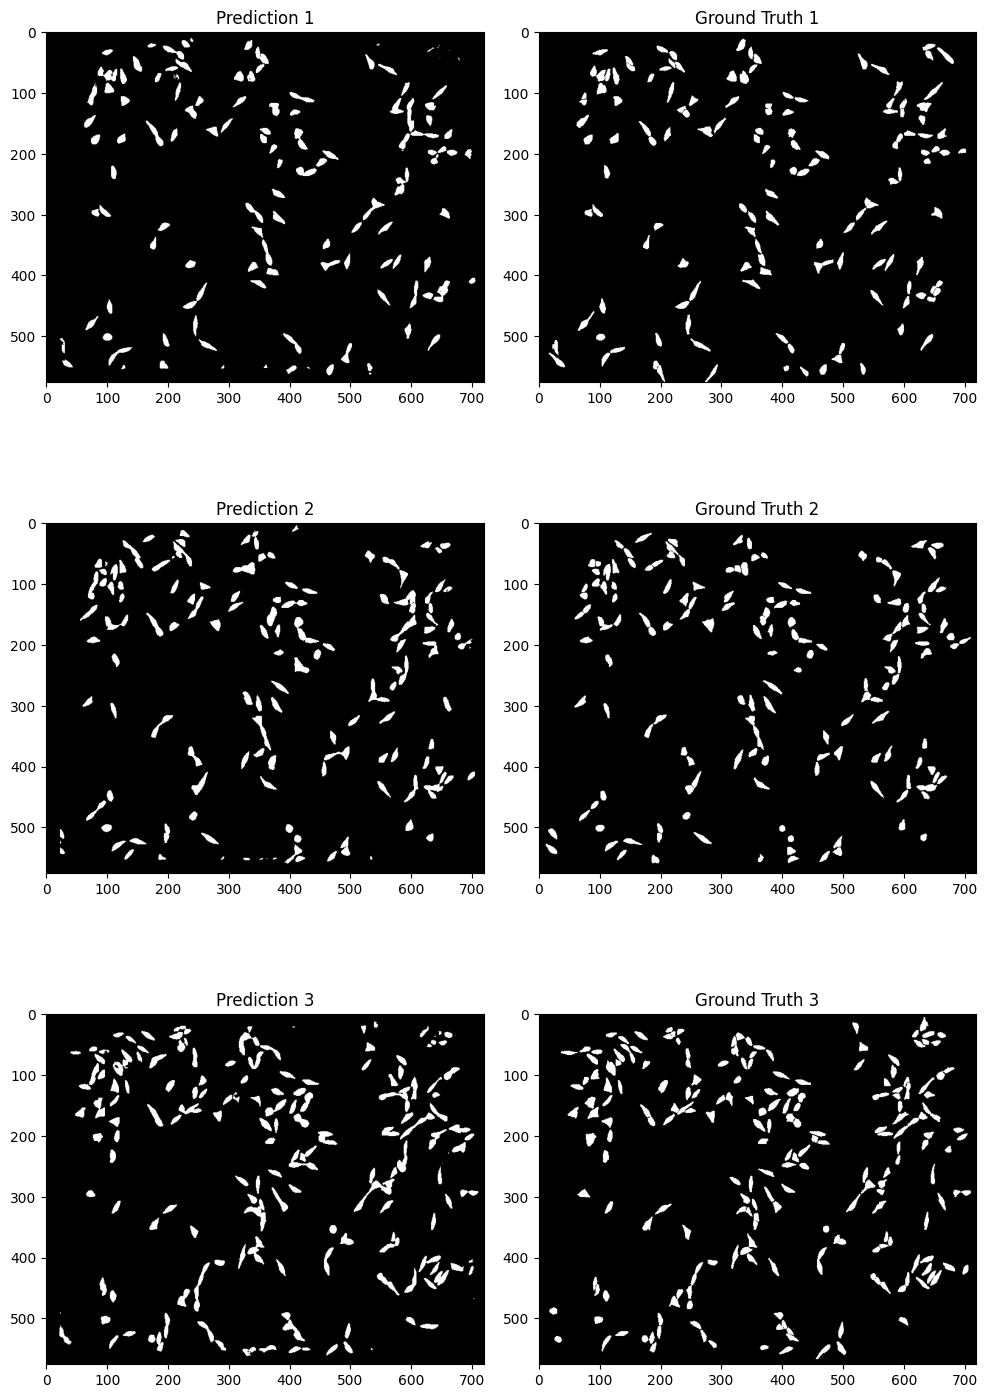

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np


# read training images
sample_mask1 = Image.open('seg_imgs/test/output/man_seg150.tif')
sample_img1 = Image.open('seg_imgs/test/input/t150.tif')


#sample_img1,sample_mask1 = random_crop_transform(sample_img1, sample_mask1)
sample_img1 = transforms.ToTensor()(sample_img1).float().to(device)
sample_mask1 = (transforms.ToTensor()(sample_mask1).float()).to(device)

sample_mask2 = Image.open('seg_imgs/test/output/man_seg170.tif')
sample_img2 = Image.open('seg_imgs/test/input/t170.tif')

#sample_img2,sample_mask2 = random_crop_transform(sample_img2, sample_mask2)
sample_img2 = transforms.ToTensor()(sample_img2).float().to(device)
sample_mask2 = (transforms.ToTensor()(sample_mask2).float()).to(device)

sample_mask3 = Image.open('seg_imgs/test/output/man_seg200.tif')
sample_img3 = Image.open('seg_imgs/test/input/t200.tif')

#sample_img3,sample_mask3 = random_crop_transform(sample_img3, sample_mask3)
sample_img3 = transforms.ToTensor()(sample_img3).float().to(device)
sample_mask3 = (transforms.ToTensor()(sample_mask3).float()).to(device)

model.eval()

with torch.no_grad():
  pred1 = torch.sigmoid(((model(sample_img1.unsqueeze(0)))))>0.94
  pred1_1 =model(sample_img1.unsqueeze(0))
  pred2 = torch.sigmoid(((model(sample_img2.unsqueeze(0)))))>0.935
  pred2_2 = model(sample_img2.unsqueeze(0))
  pred3 = torch.sigmoid(((model(sample_img3.unsqueeze(0)))))>0.935
  pred3_3 = model(sample_img3.unsqueeze(0))

print("img 1 iou :",calculate_iou(pred1_1,sample_mask1))
print("img 2 iou :",calculate_iou(pred2_2,sample_mask2))
print("img 3 iou :",calculate_iou(pred3_3,sample_mask3))

def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy().squeeze()

pred1_np = tensor_to_numpy(pred1)
pred2_np = tensor_to_numpy(pred2)
pred3_np = tensor_to_numpy(pred3)

mask1_np = tensor_to_numpy(sample_mask1)
mask2_np = tensor_to_numpy(sample_mask2)
mask3_np = tensor_to_numpy(sample_mask3)

fig, axs = plt.subplots(3, 2, figsize=(10, 15))

axs[0, 0].imshow(pred1_np, cmap='gray')
axs[0, 0].set_title('Prediction 1')
axs[0, 1].imshow(mask1_np, cmap='gray')
axs[0, 1].set_title('Ground Truth 1')

axs[1, 0].imshow(pred2_np, cmap='gray')
axs[1, 0].set_title('Prediction 2')
axs[1, 1].imshow(mask2_np, cmap='gray')
axs[1, 1].set_title('Ground Truth 2')

axs[2, 0].imshow(pred3_np, cmap='gray')
axs[2, 0].set_title('Prediction 3')
axs[2, 1].imshow(mask3_np, cmap='gray')
axs[2, 1].set_title('Ground Truth 3')

plt.tight_layout()
plt.show()

# **Tracking**
On recharge le seg_loader sans shuffle pour que l'ordre des frames soit maintenu pour la suite.

In [ ]:
test_seg_loader = DataLoader(seg_test_dataset, batch_size=8, shuffle=False)

Ajout de toutes les images segmentées à une liste

In [ ]:
import cv2
import numpy as np
import torch
from tqdm import tqdm

total_accuracy = 0
total_iou = 0
model.eval()

segmented_frames = []
model.eval()
for index, (images, masks) in enumerate(tqdm(test_seg_loader)):
    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)

        acc = calculate_accuracy(preds, masks)
        total_accuracy += acc

        iou = calculate_iou(preds, masks)
        total_iou += iou

        preds_binary = (torch.sigmoid(preds) > 0.92).cpu().numpy().astype(np.uint8)
        segmented_frames.extend(preds_binary[:, 0, :, :])

epoch_accuracy = total_accuracy / len(test_seg_loader)
epoch_iou = total_iou / len(test_seg_loader)
print(f'Test_Accuracy: {epoch_accuracy:.2f}, Test_IoU: {epoch_iou:.2f}')

100%|██████████| 11/11 [00:01<00:00,  6.19it/s]

Test_Accuracy: 0.92, Test_IoU: 0.77


# **Tracking basé sur les centroides et la distance euclidienne : voir rapport**
Nous colorons les résultats (avec une couleur par objet sur toutes les frames) sur les prédictions du modele de segmentation.
Une vidéo du résultat final est disponible dans le zip du rendu.

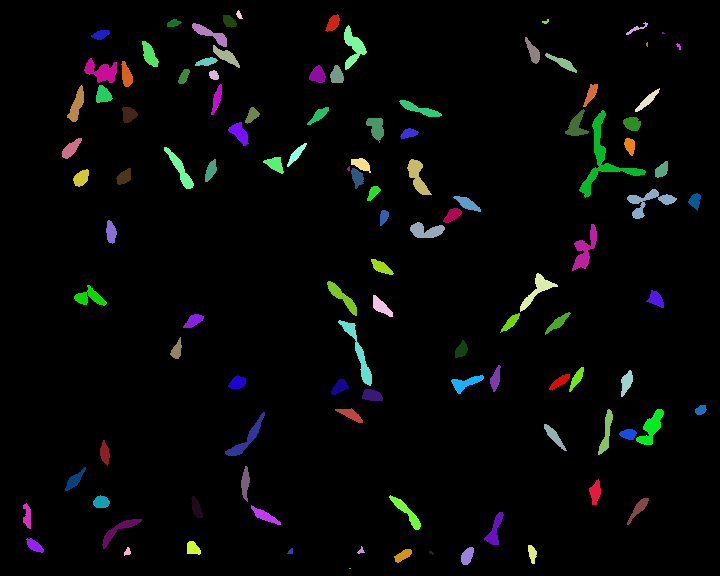

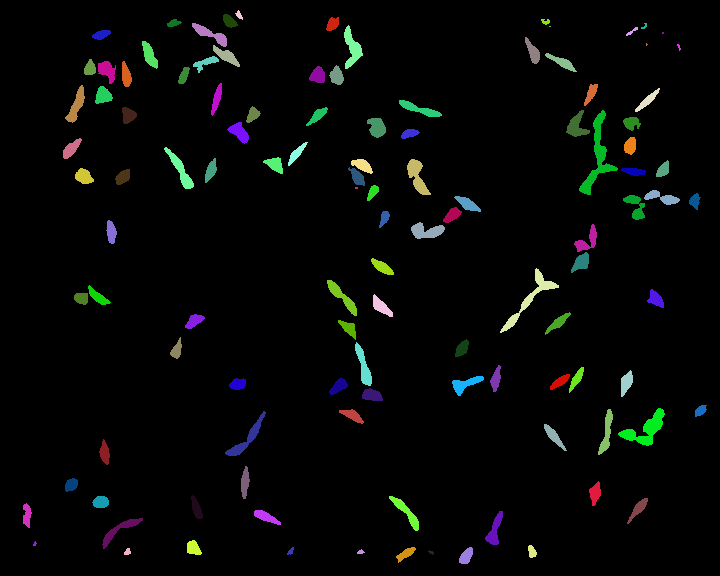

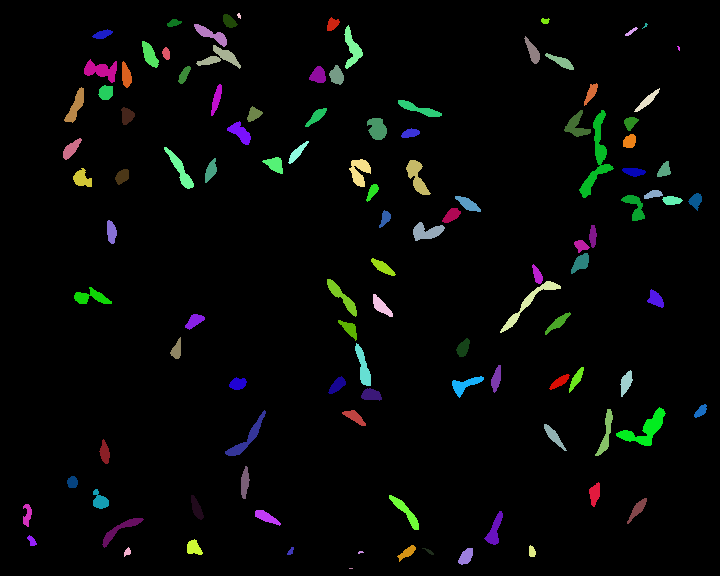

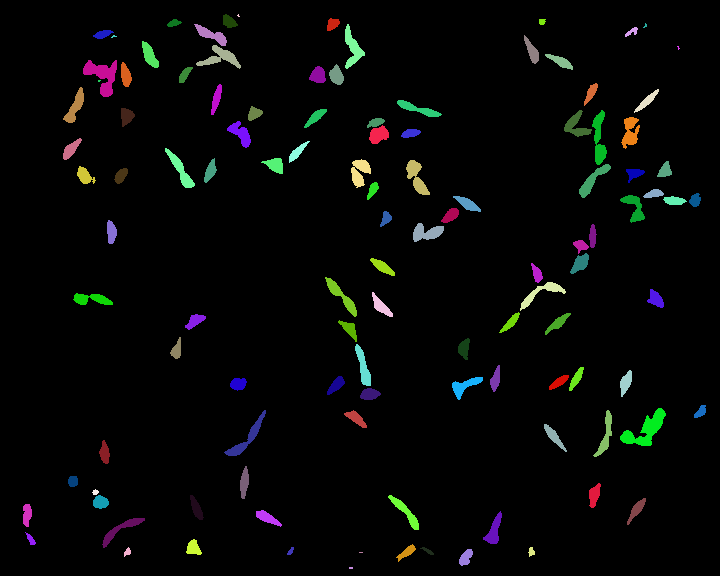

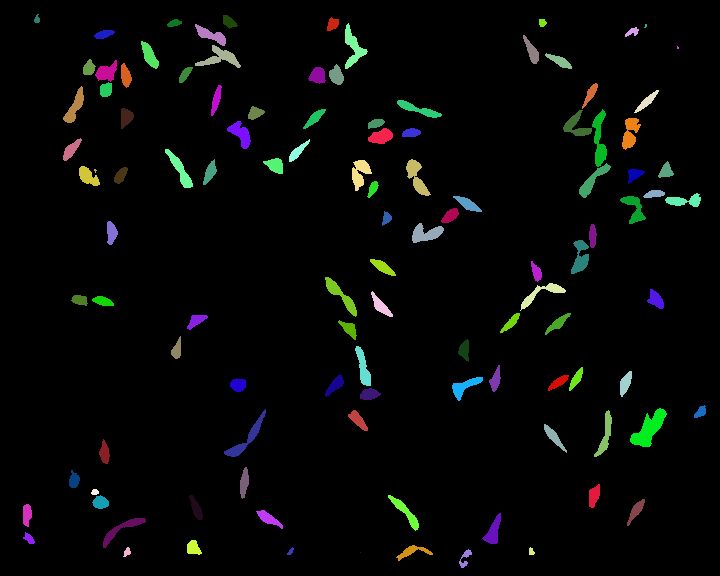

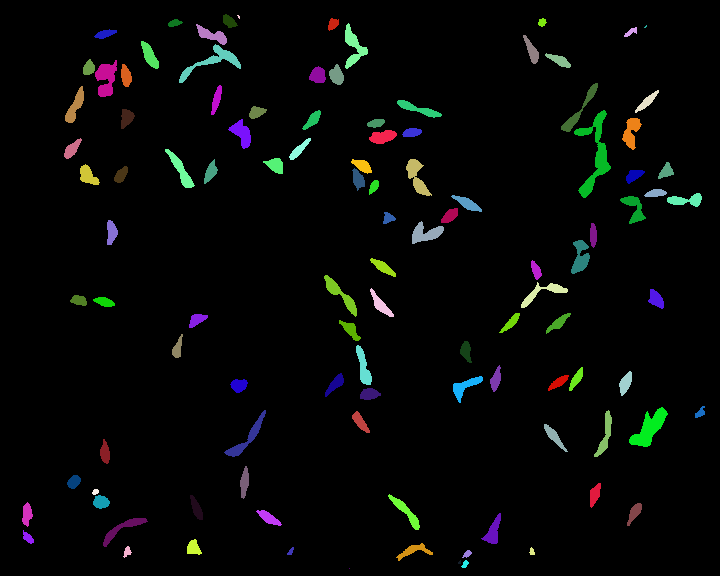

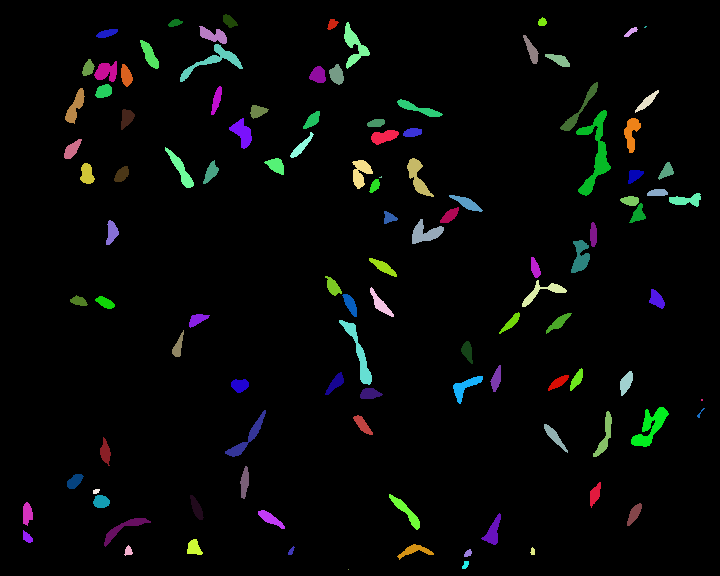

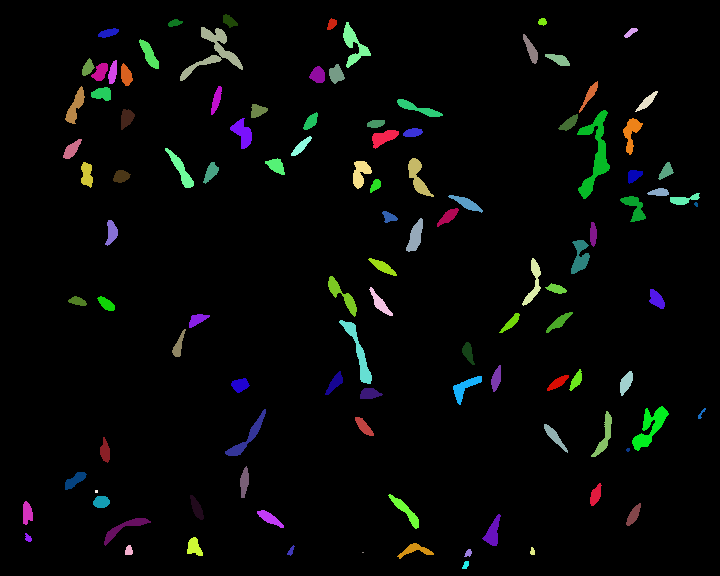

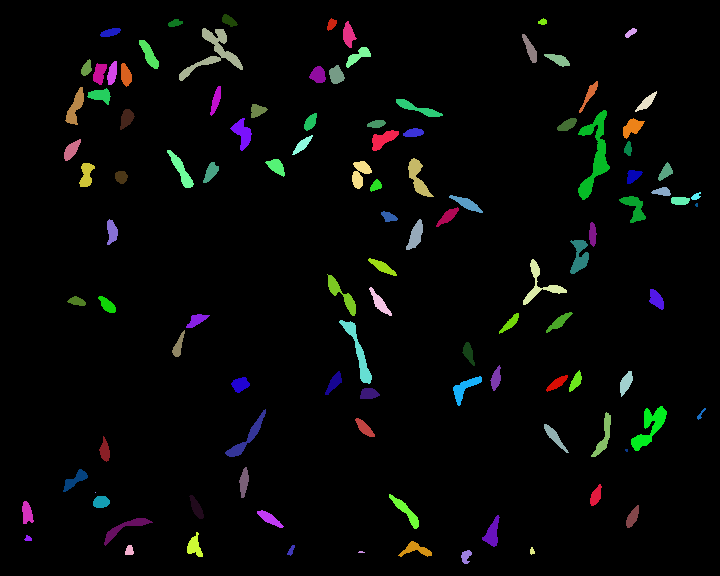

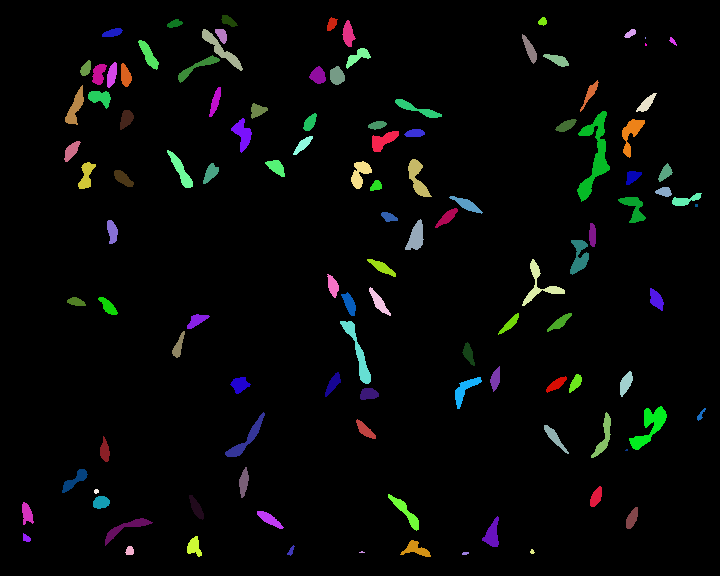

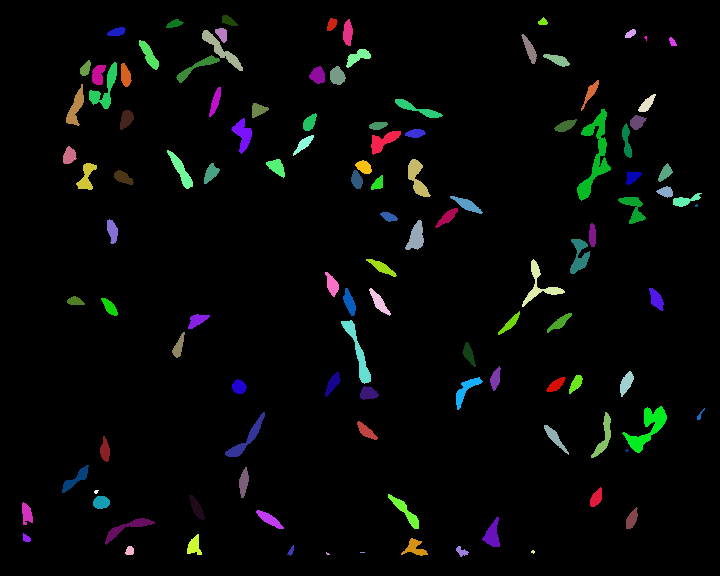

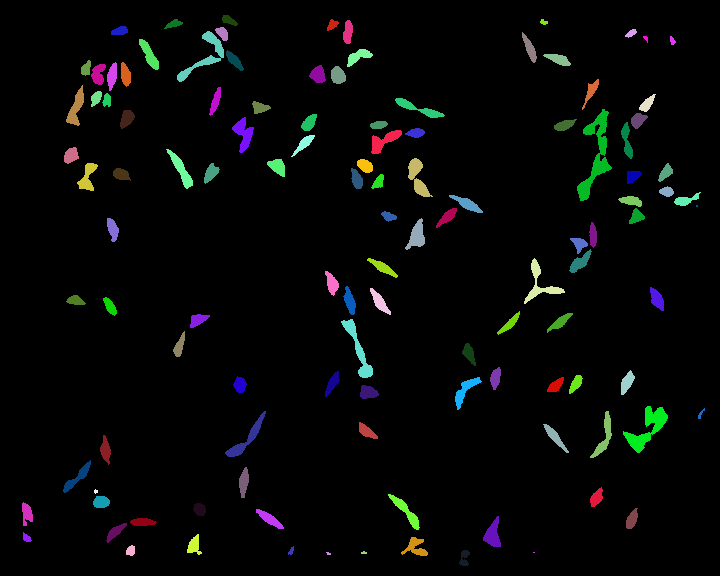

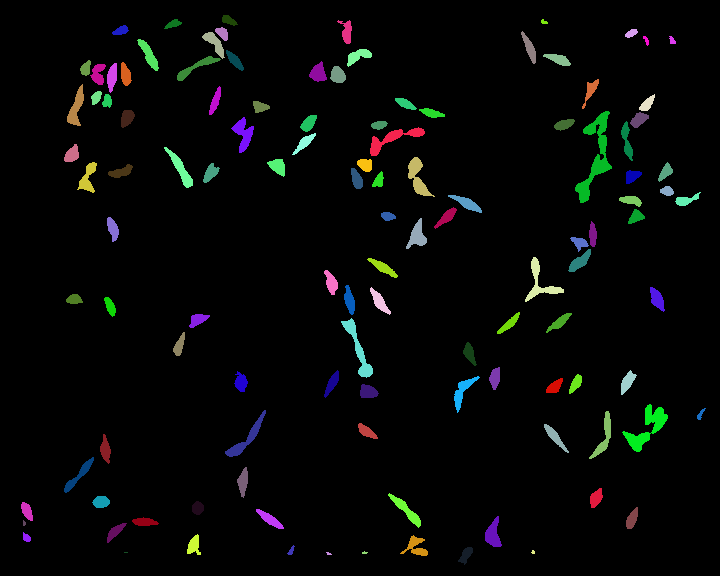

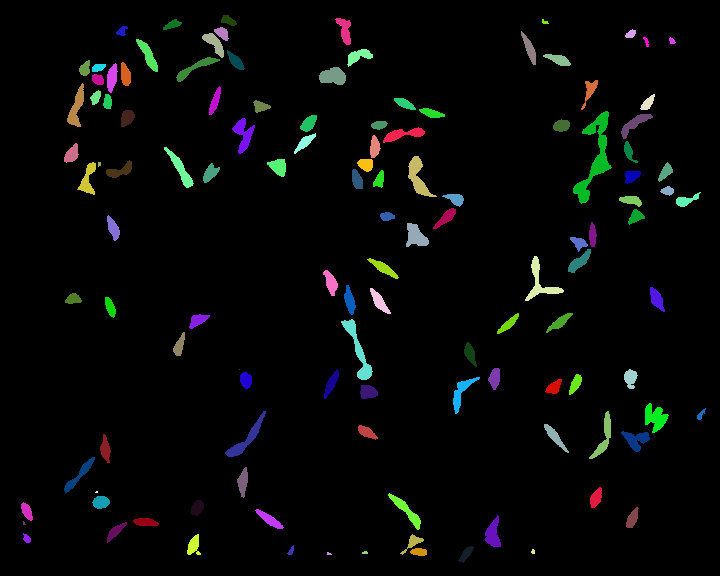

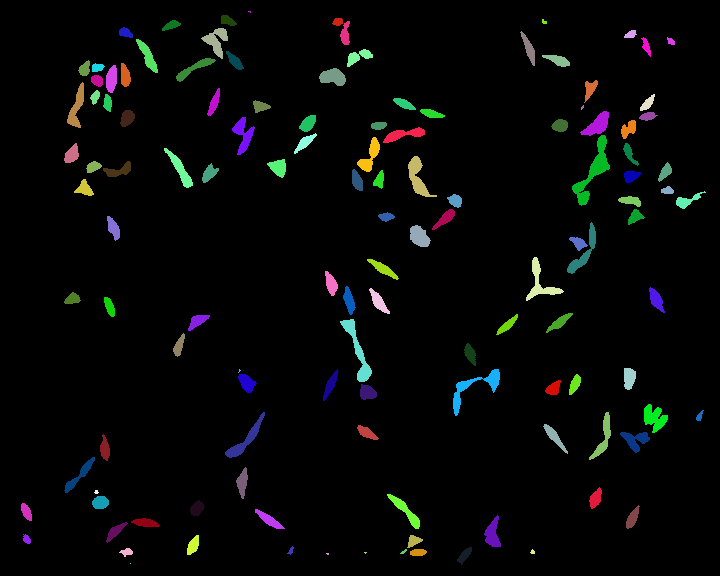

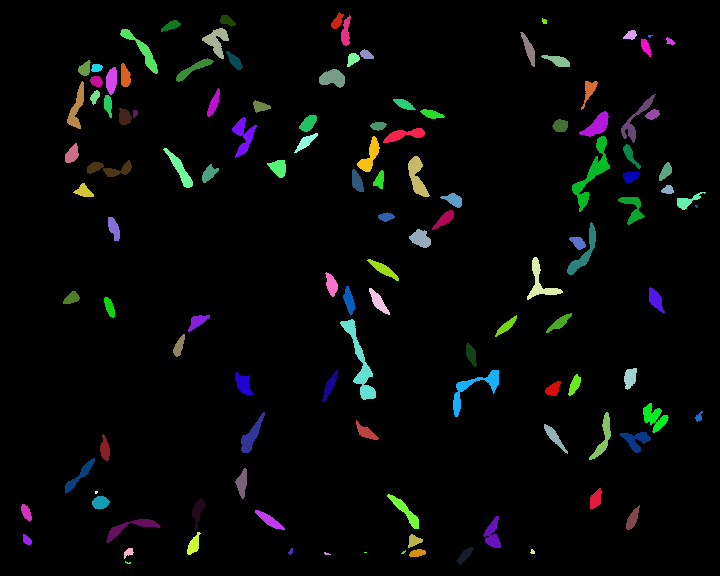

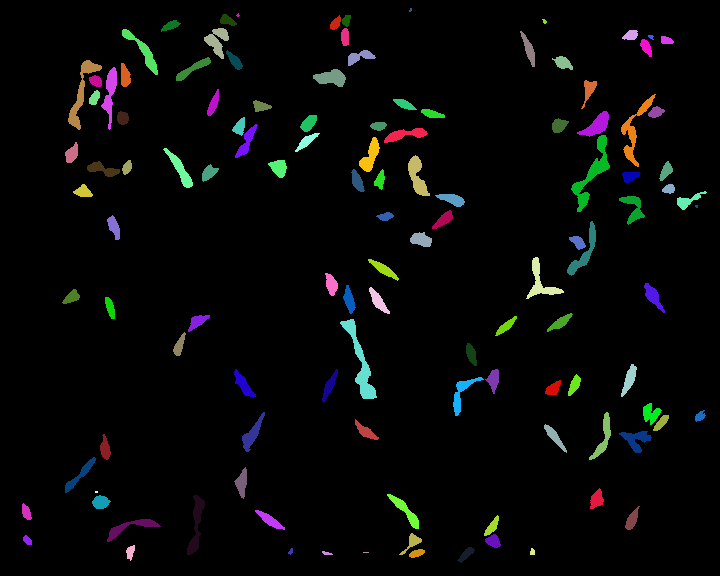

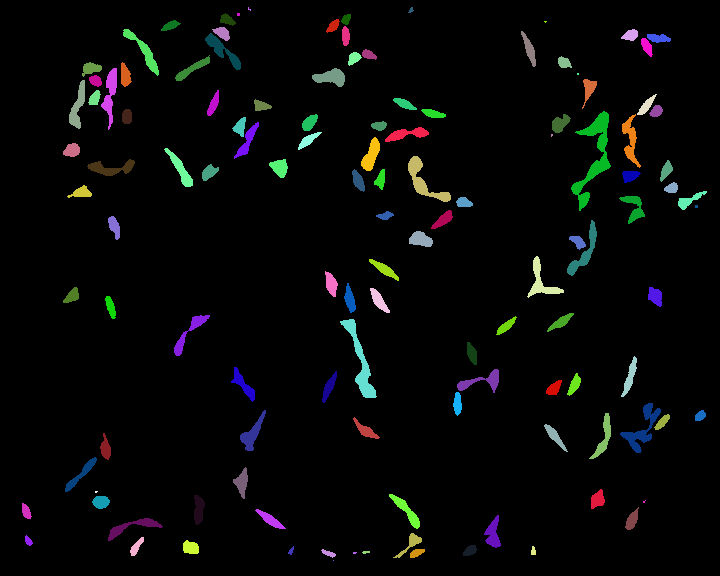

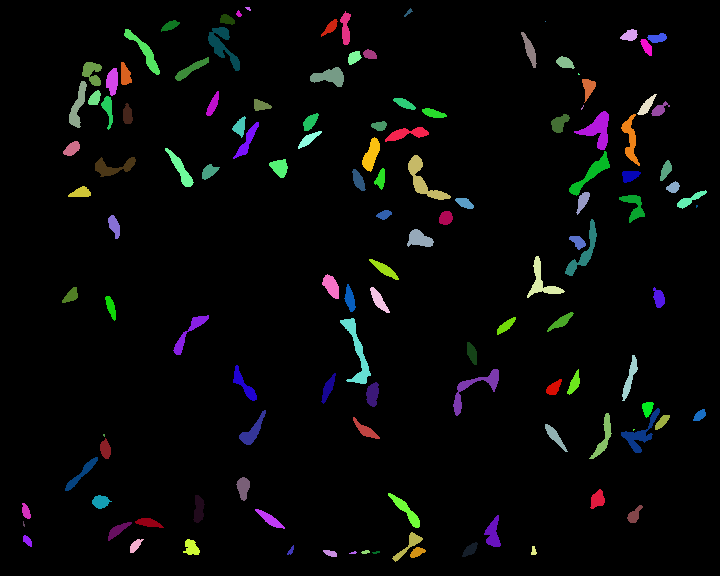

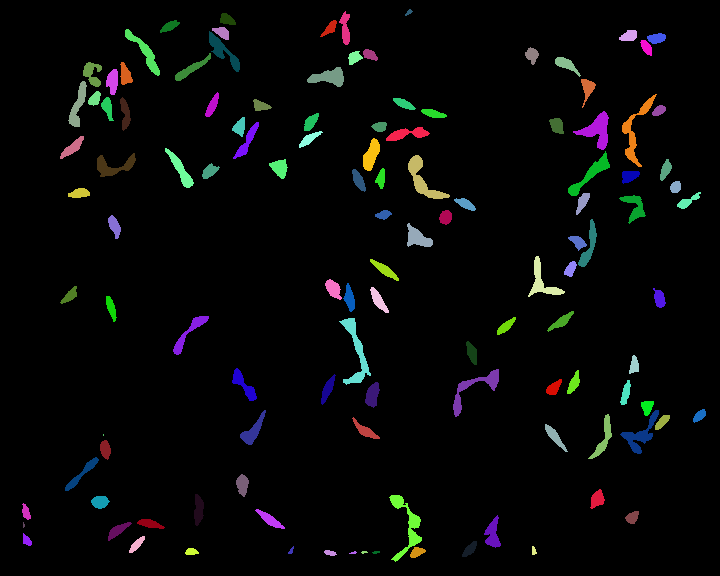

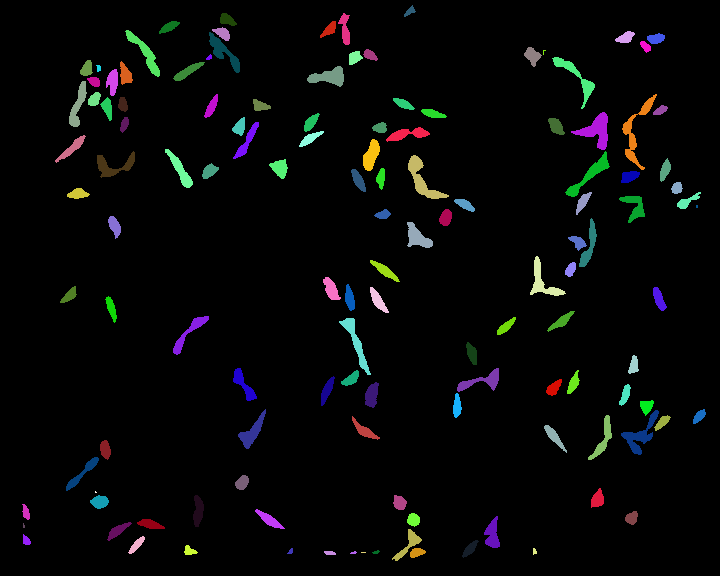

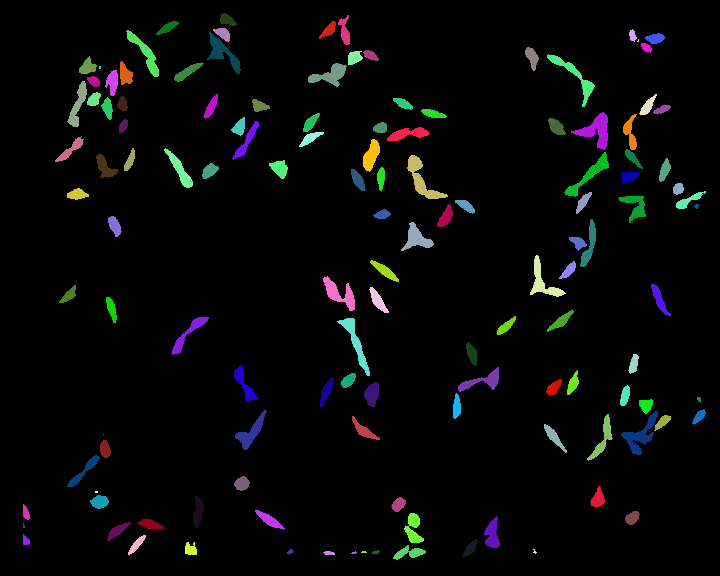

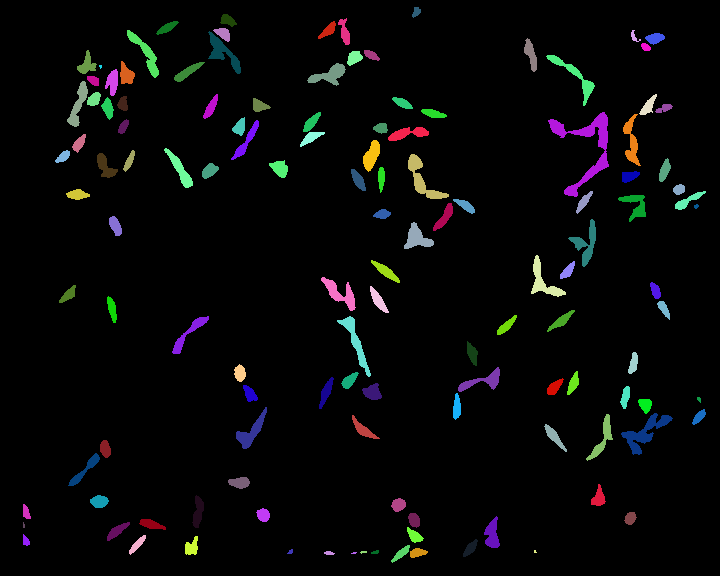

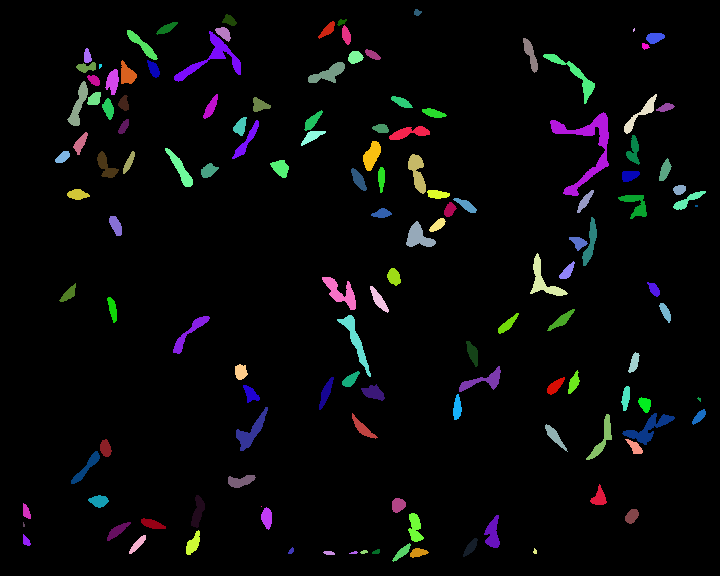

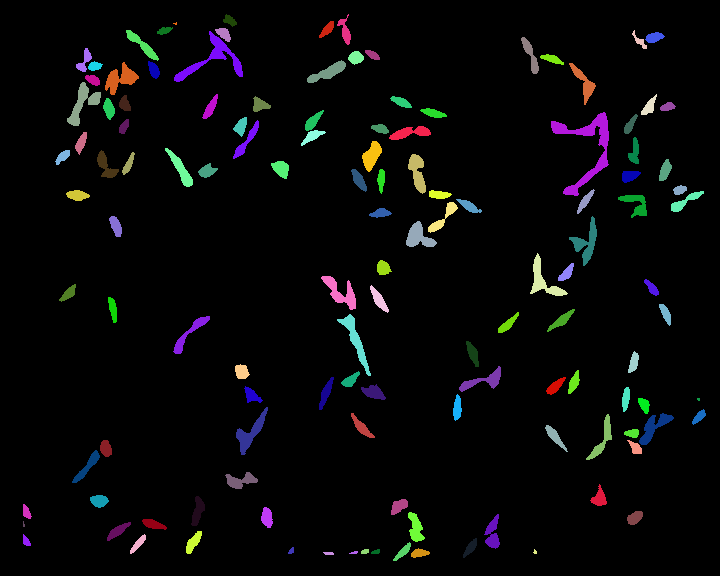

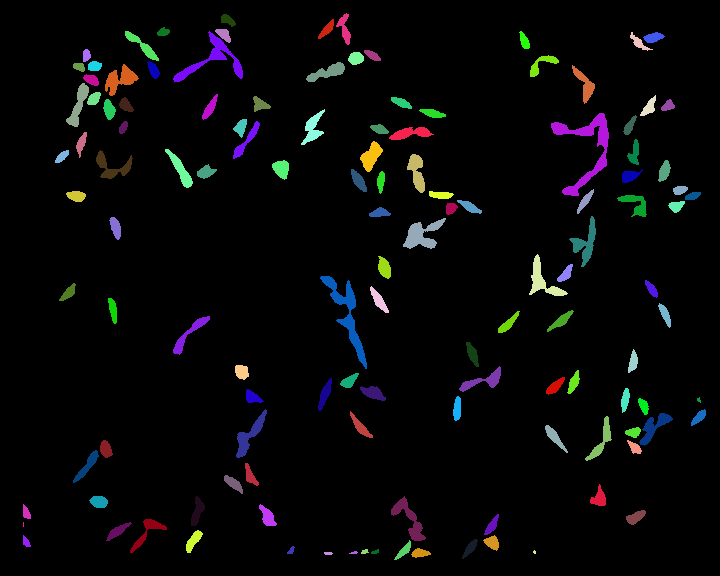

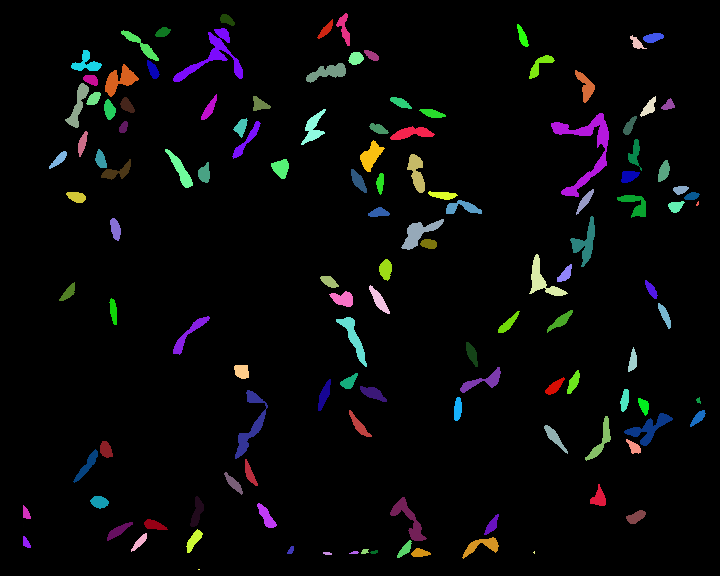

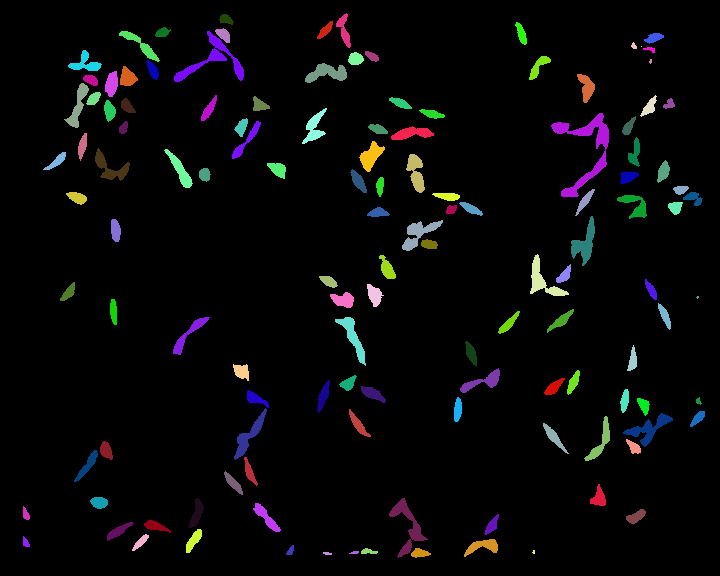

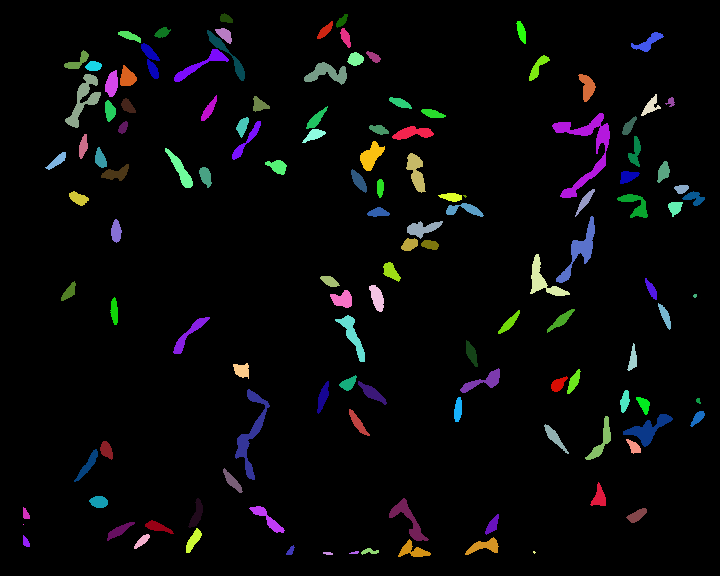

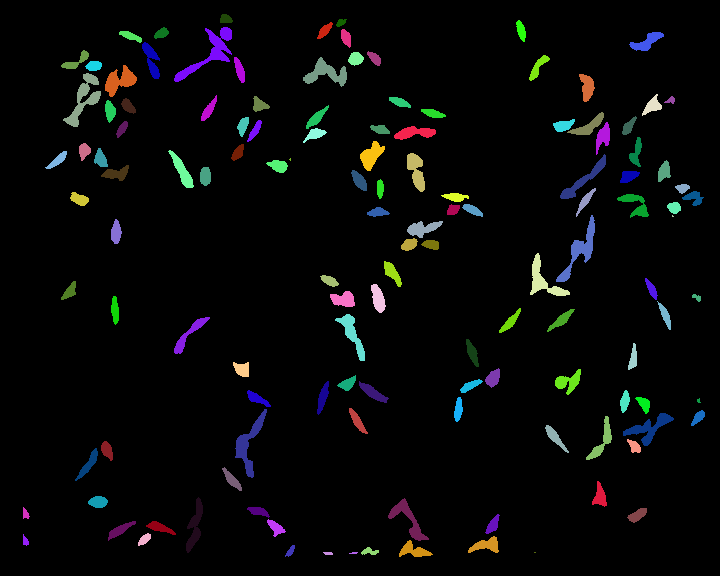

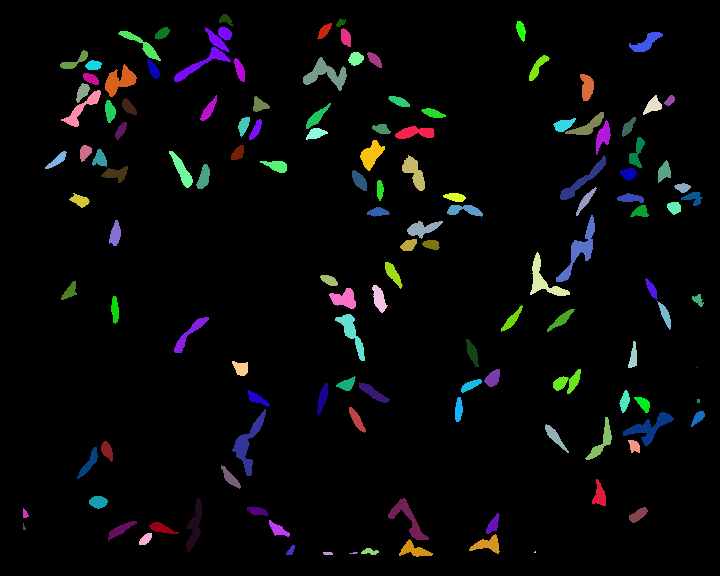

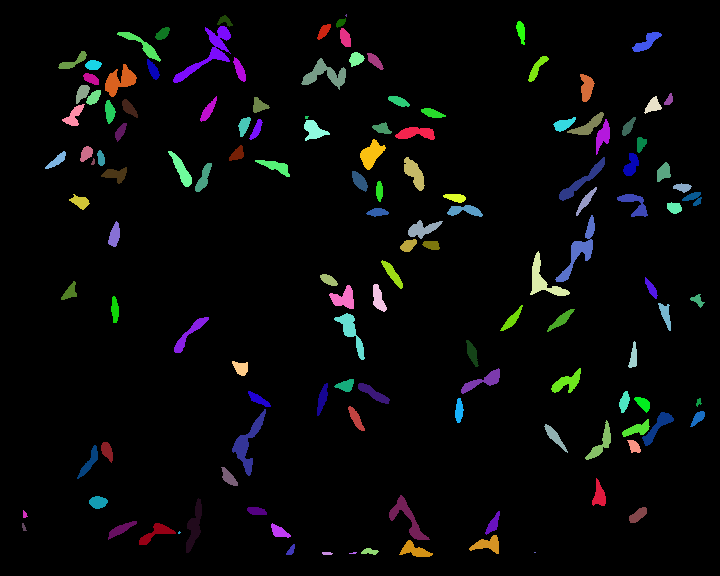

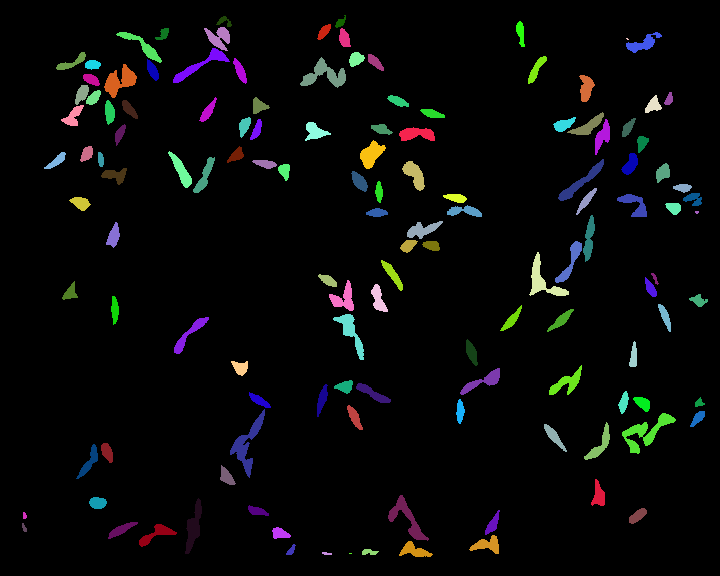

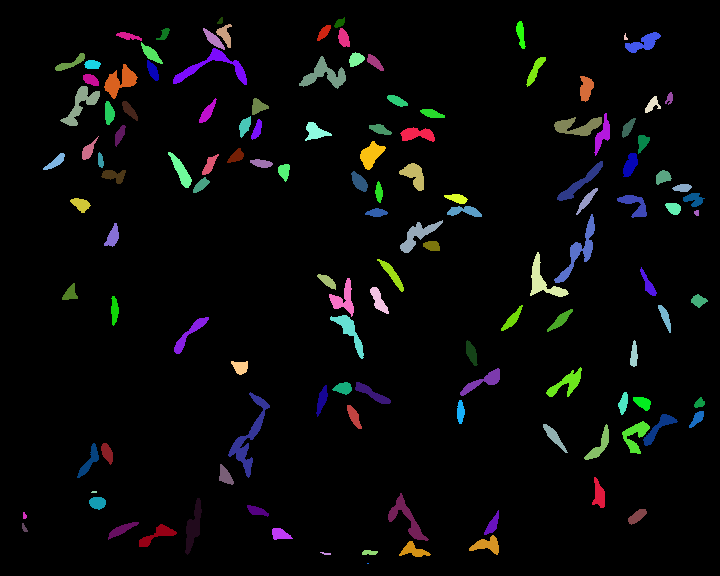

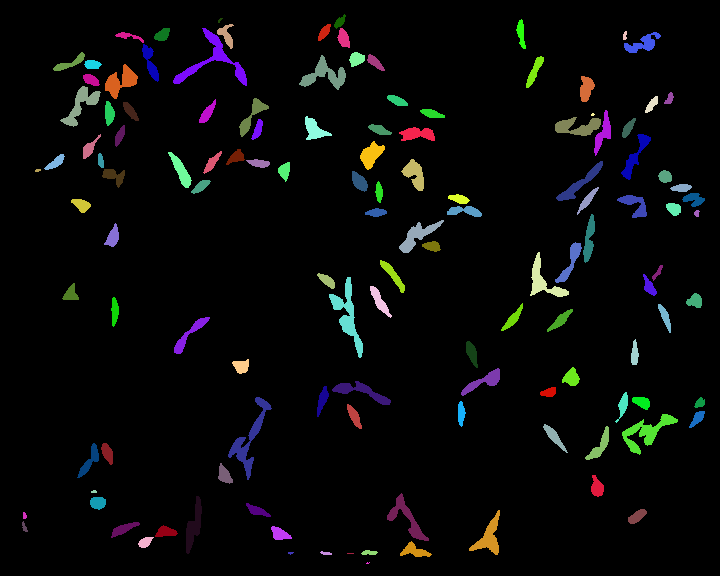

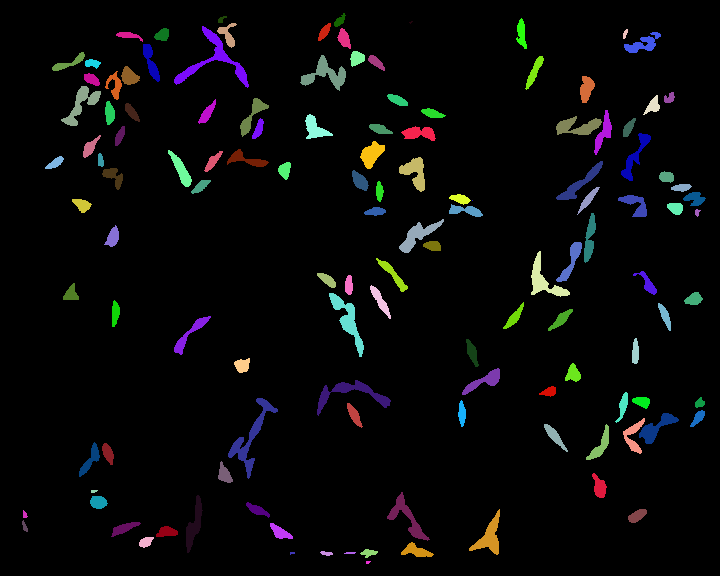

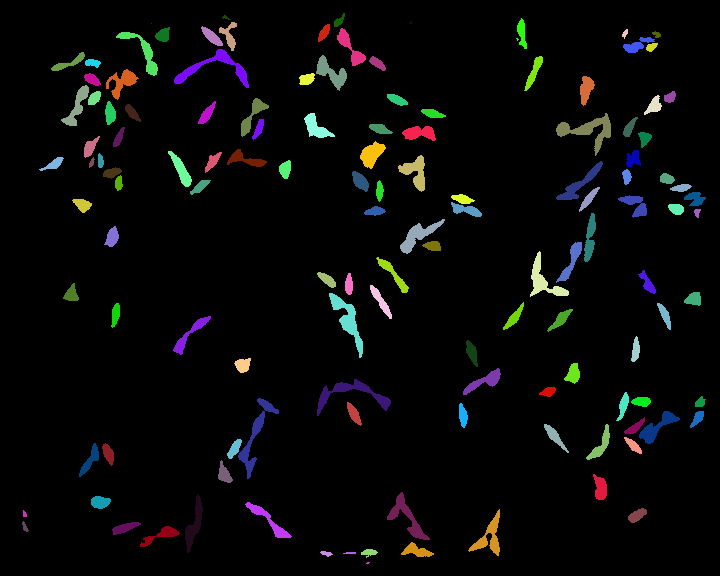

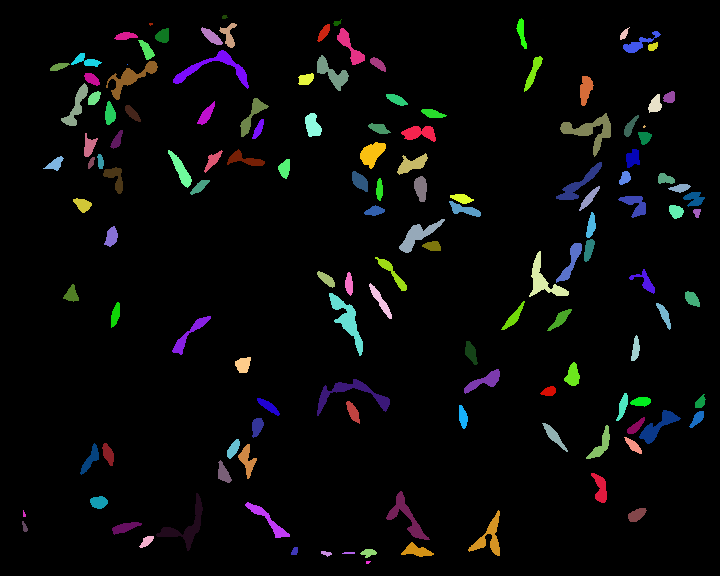

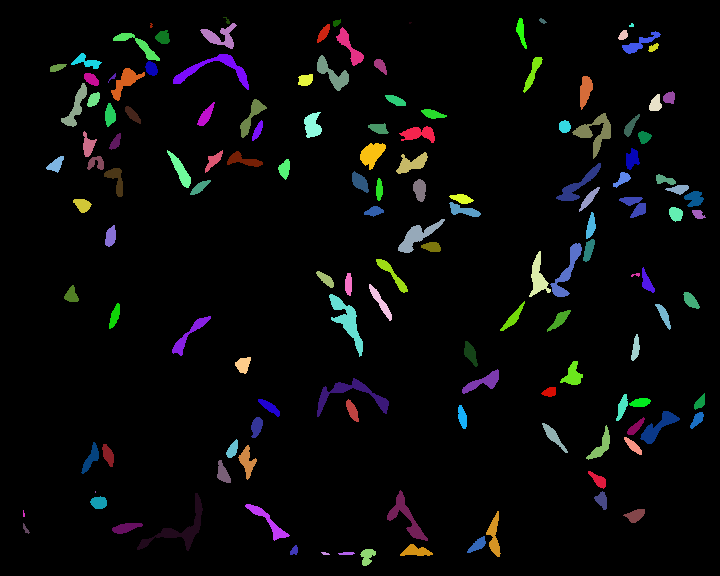

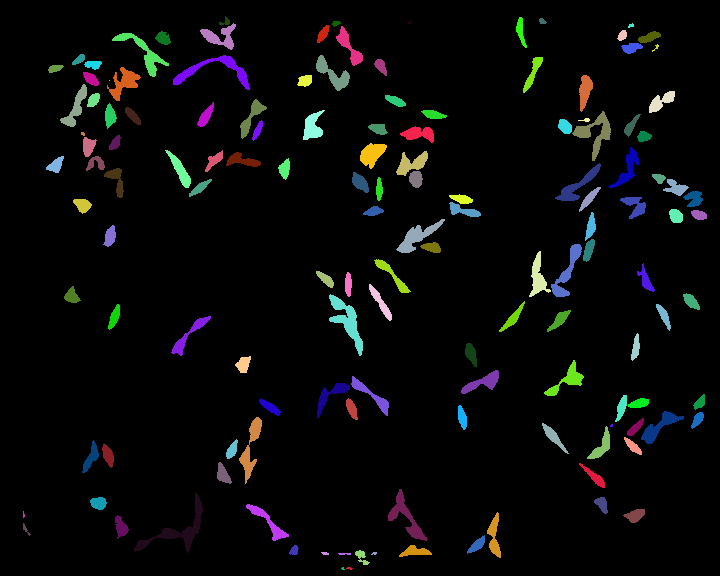

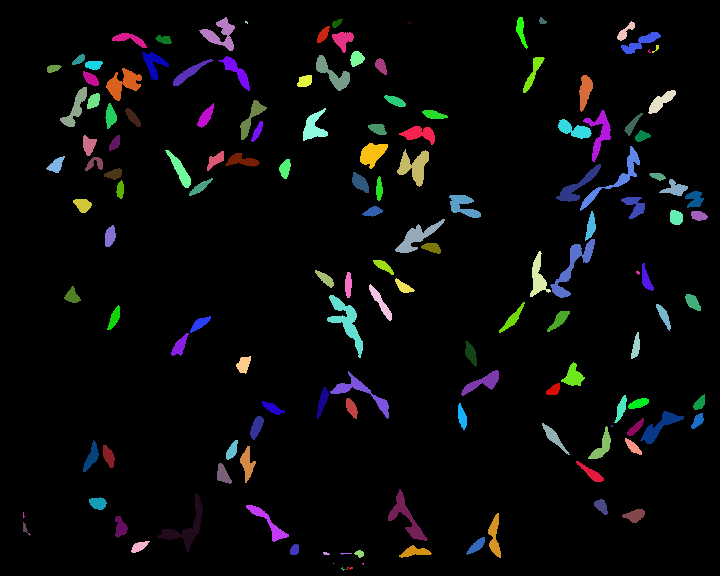

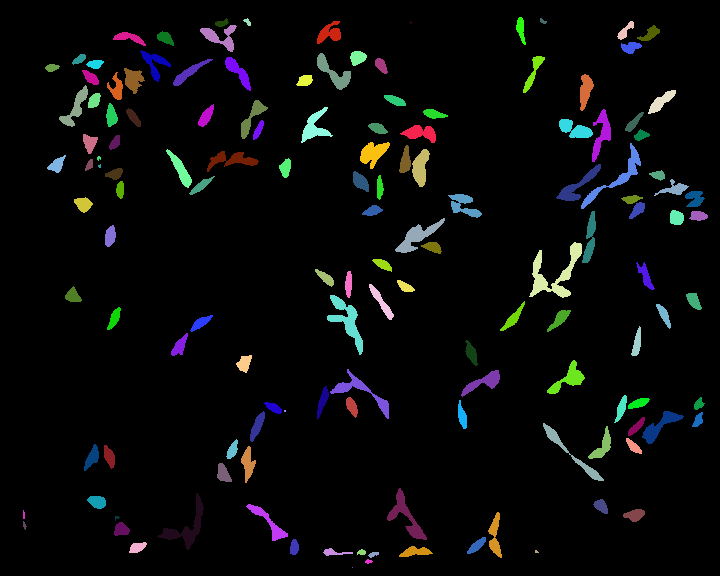

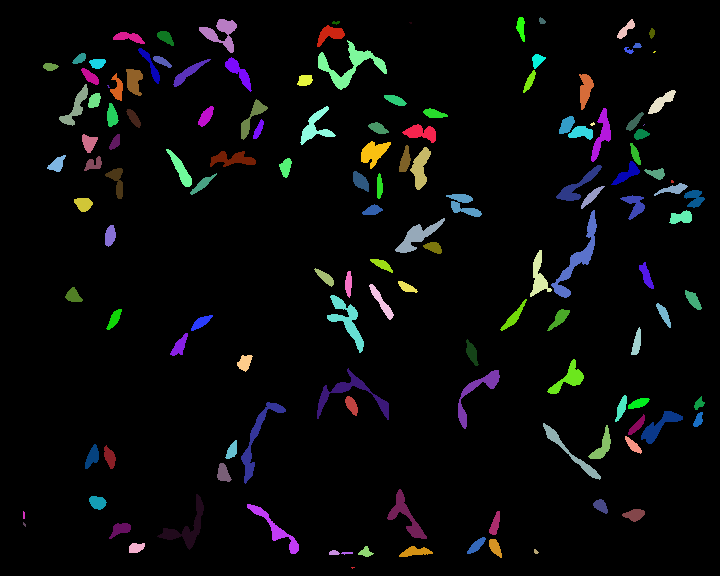

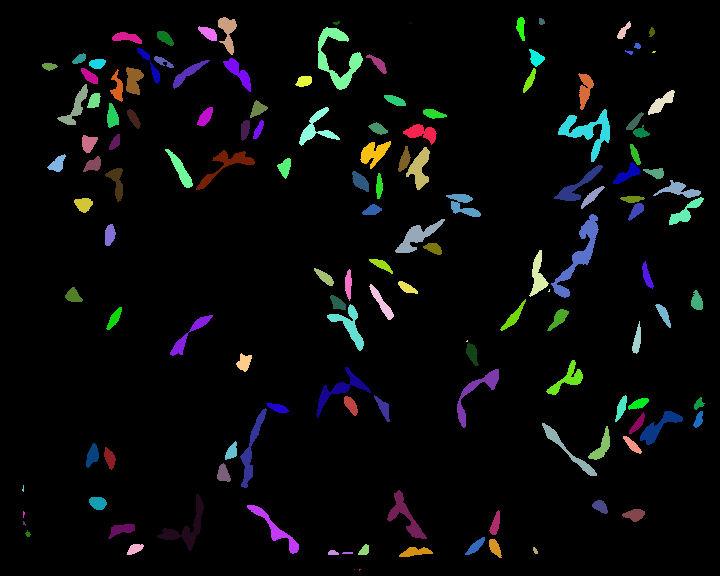

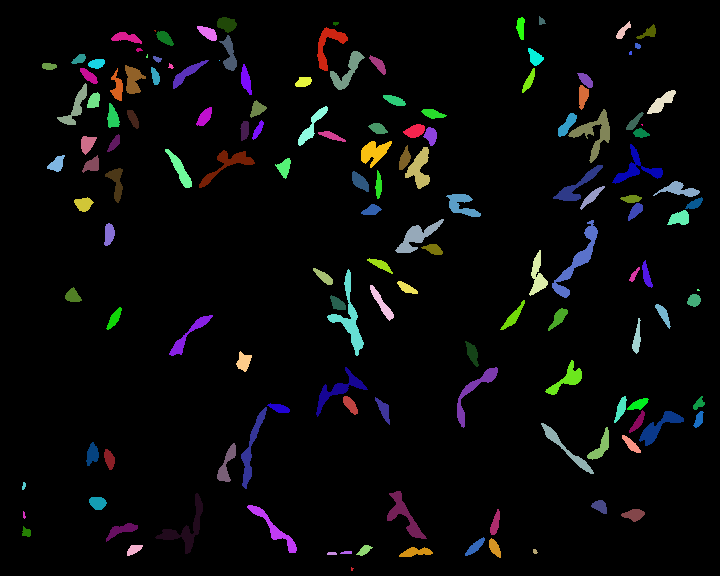

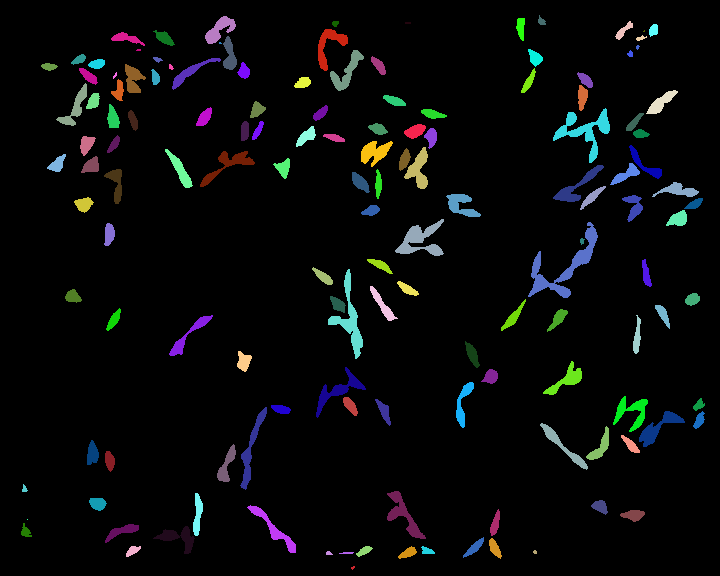

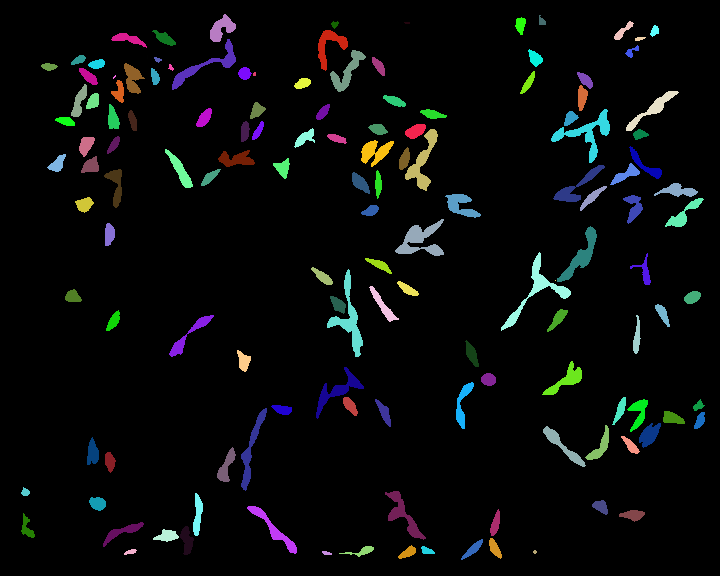

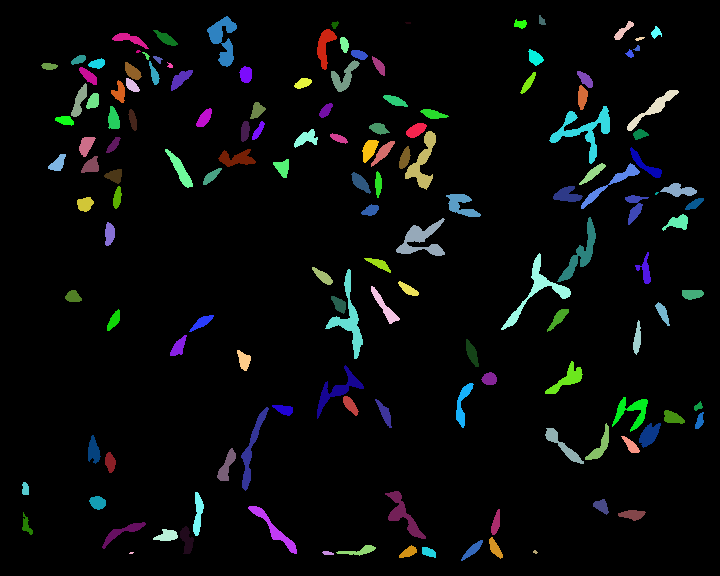

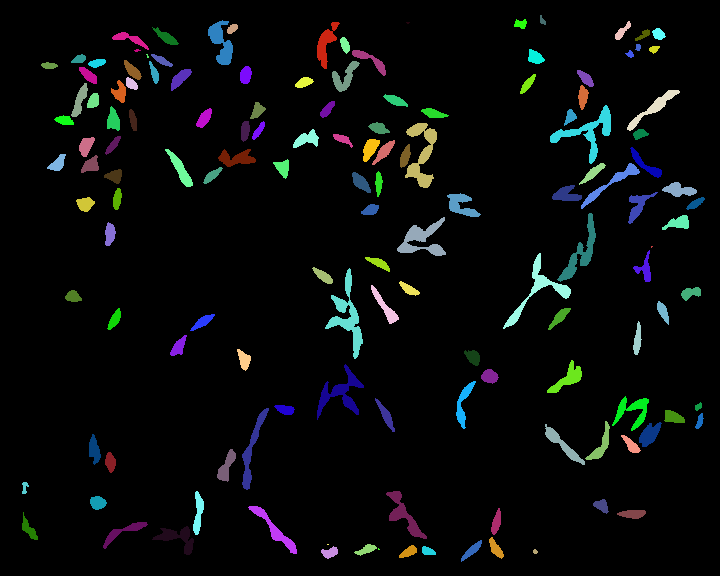

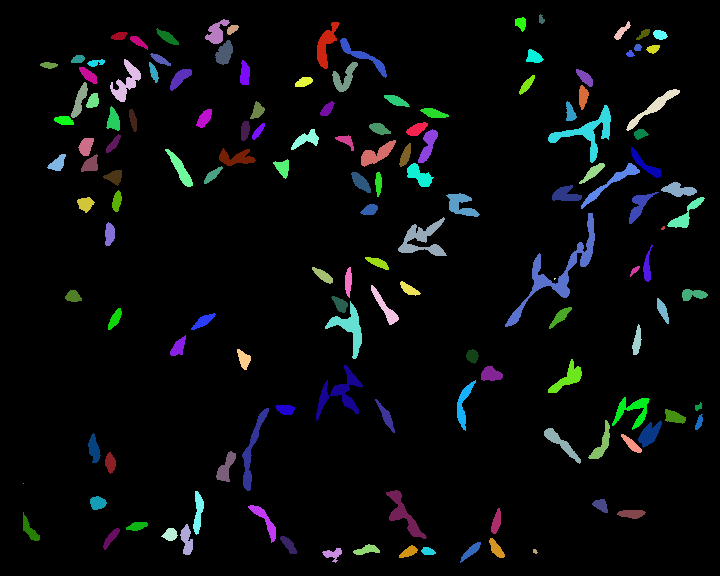

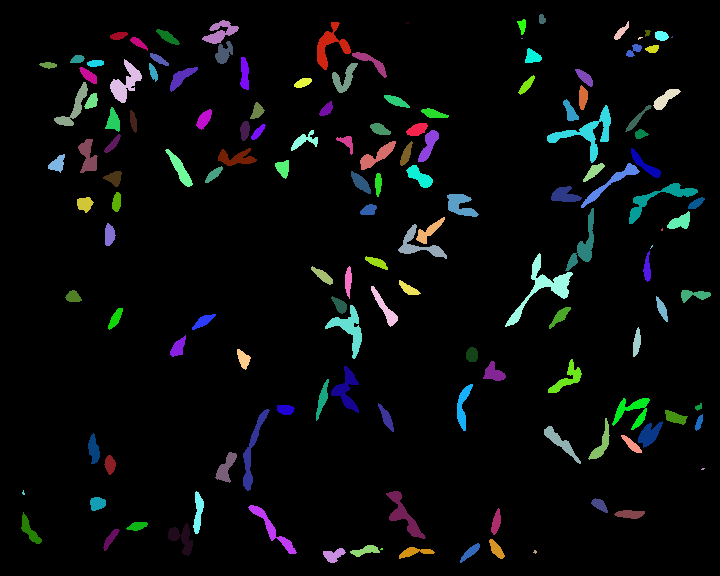

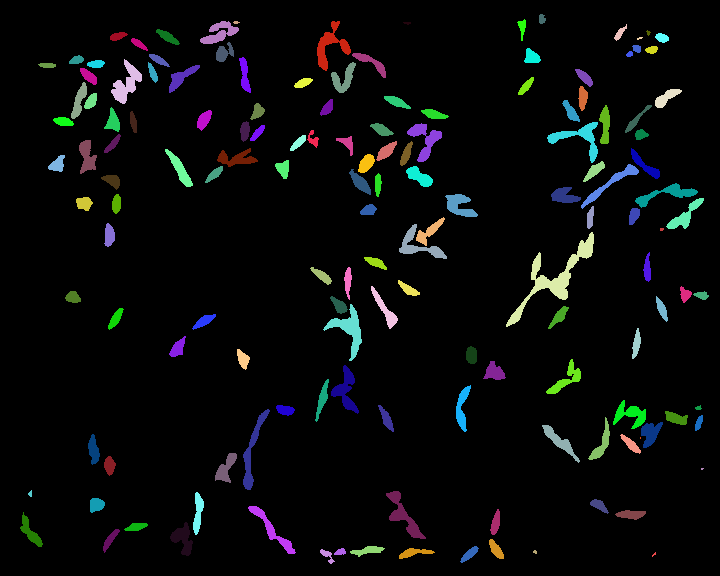

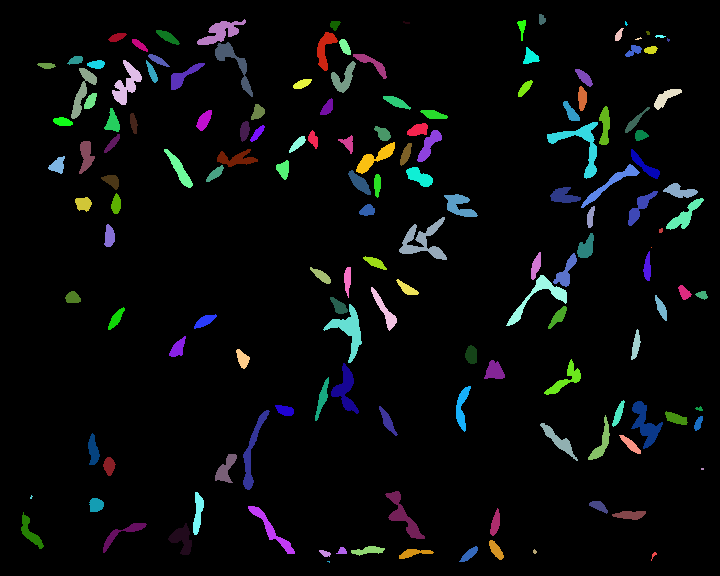

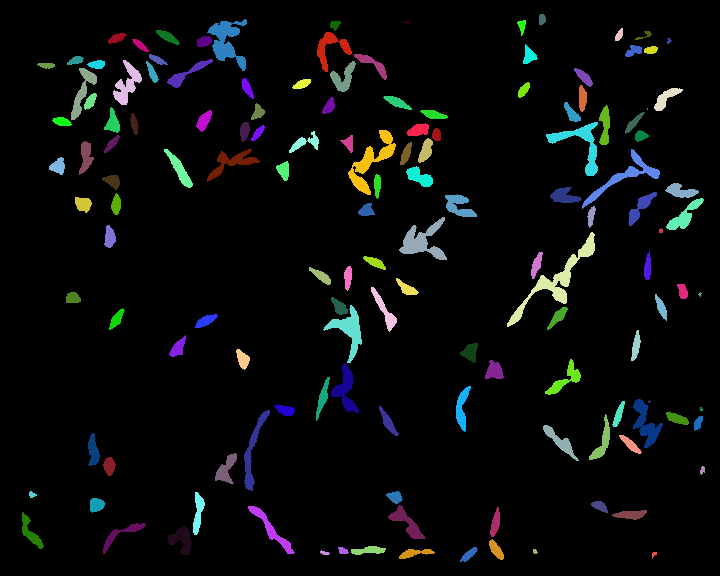

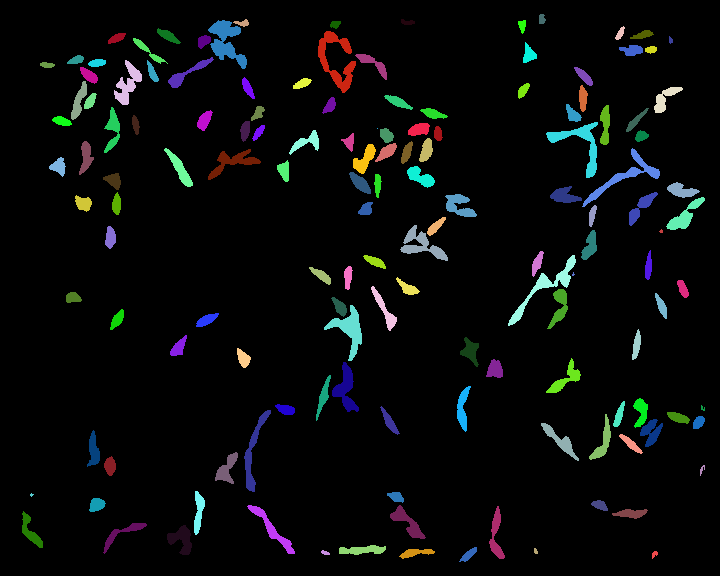

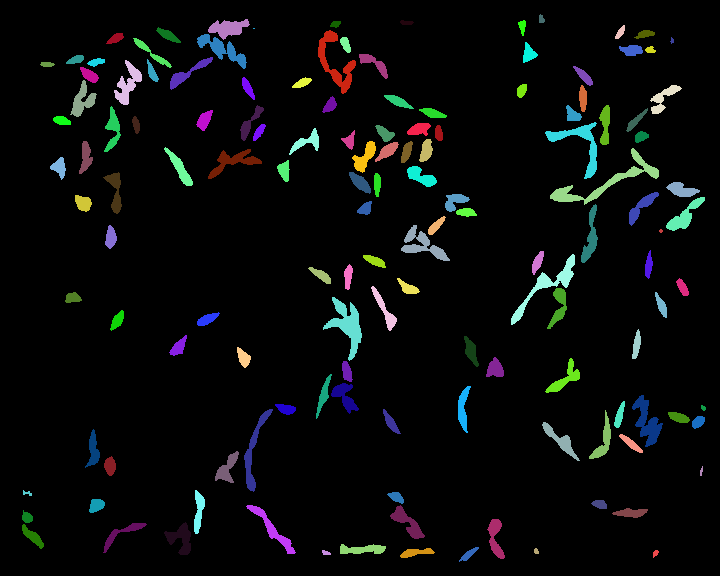

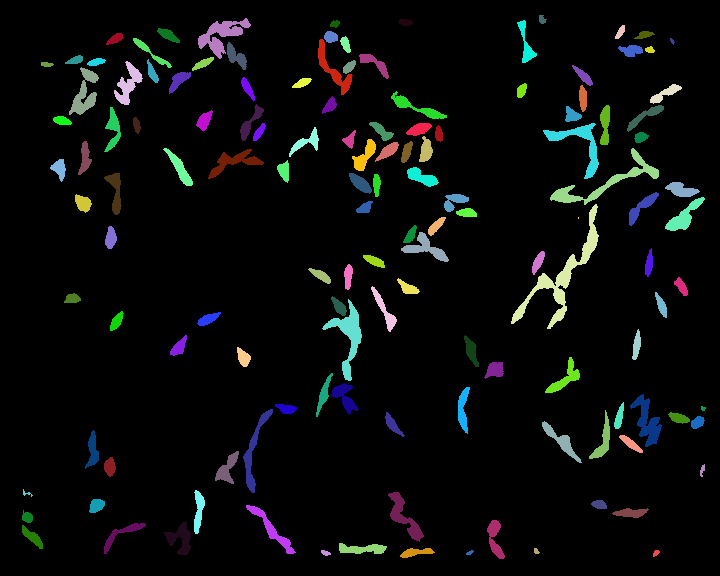

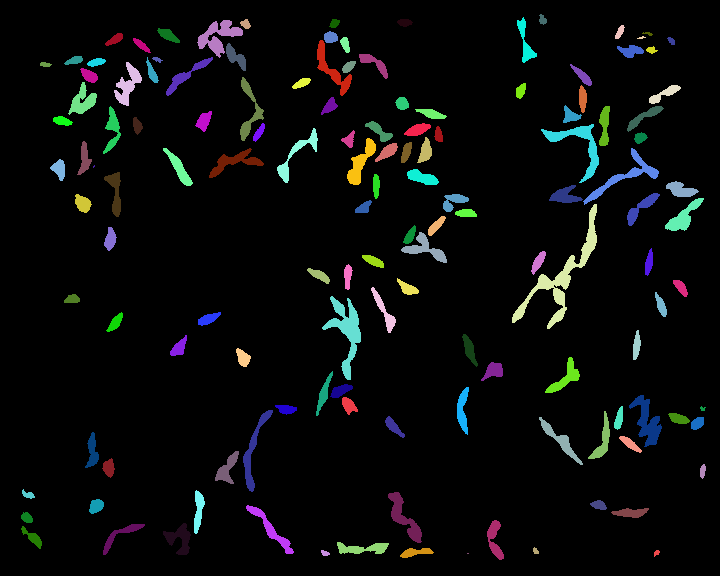

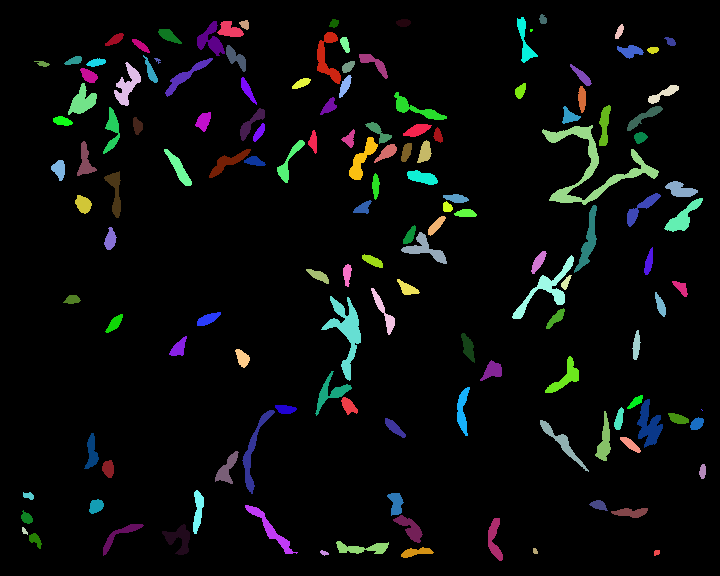

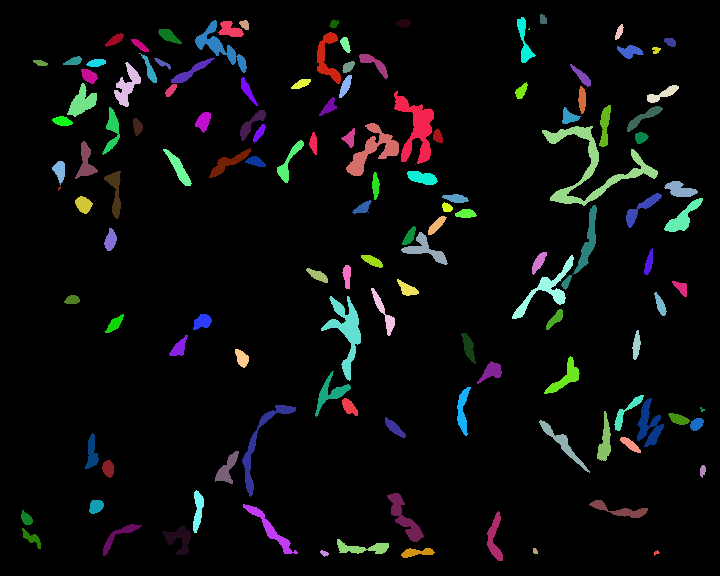

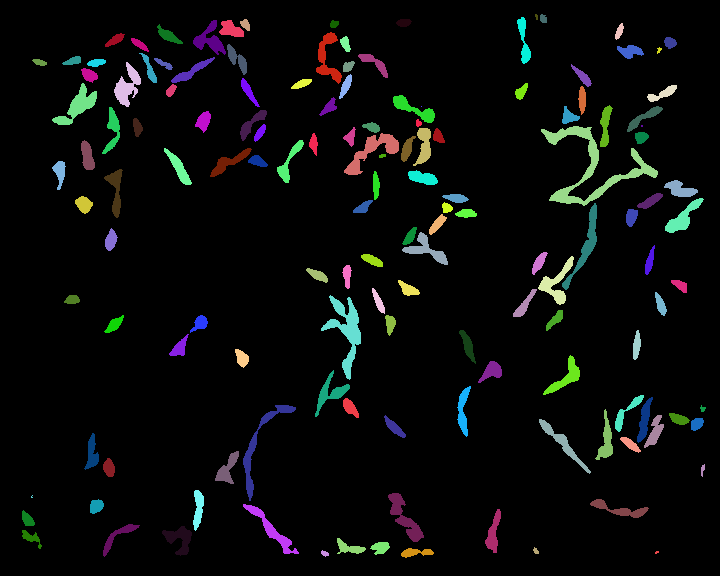

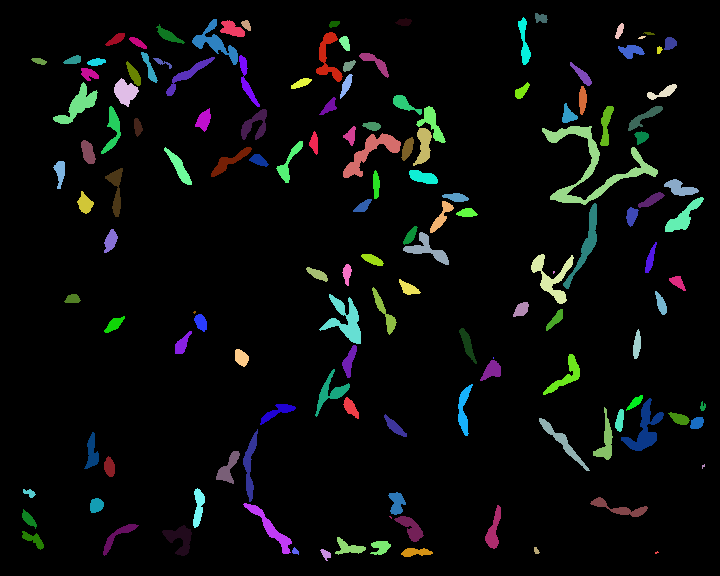

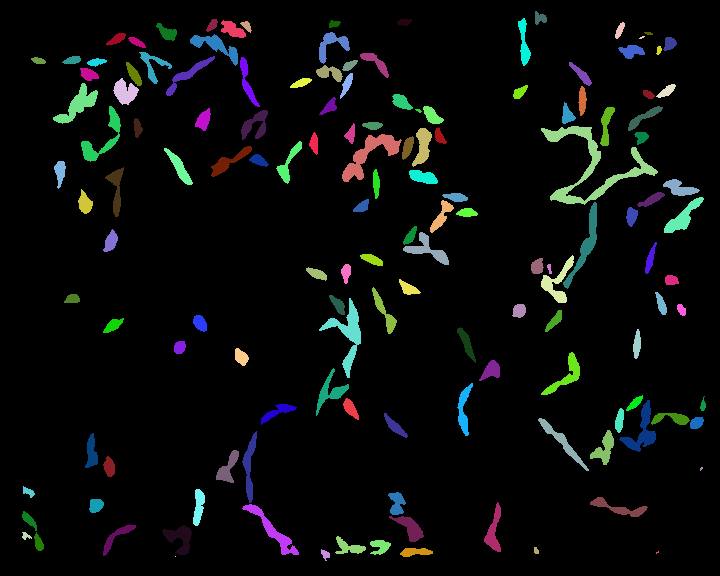

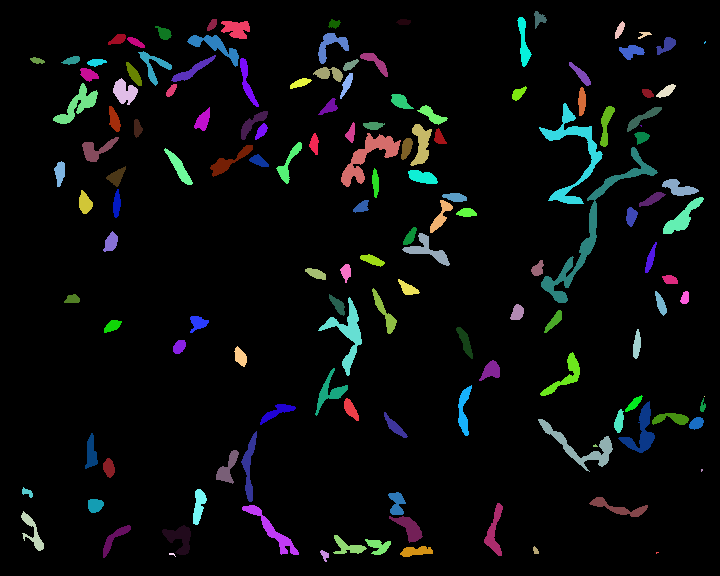

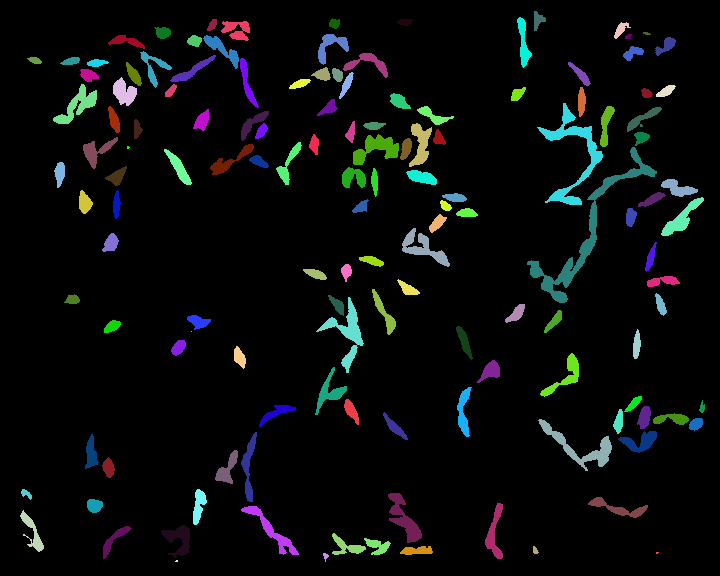

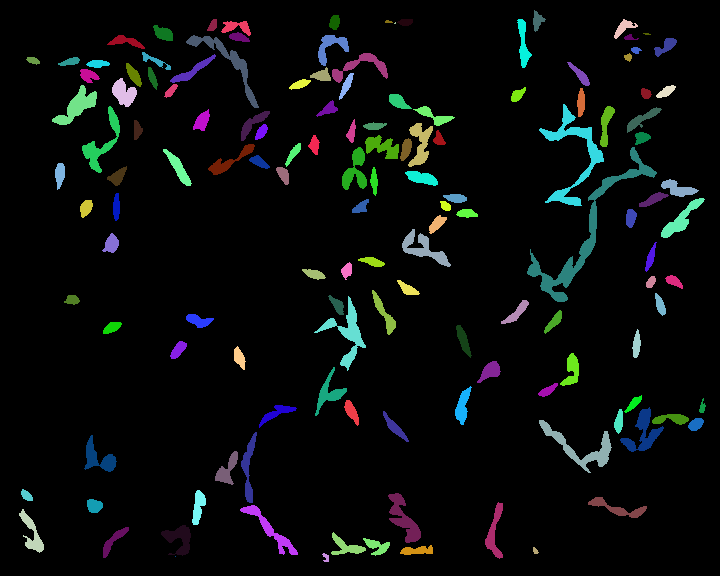

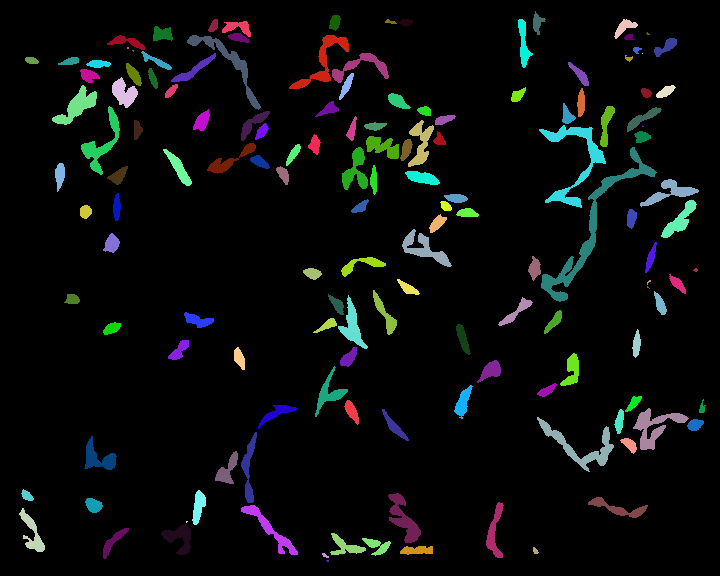

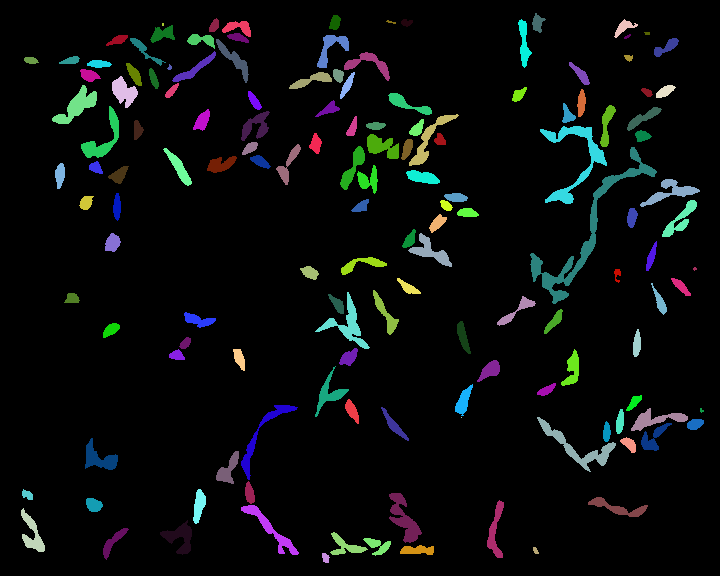

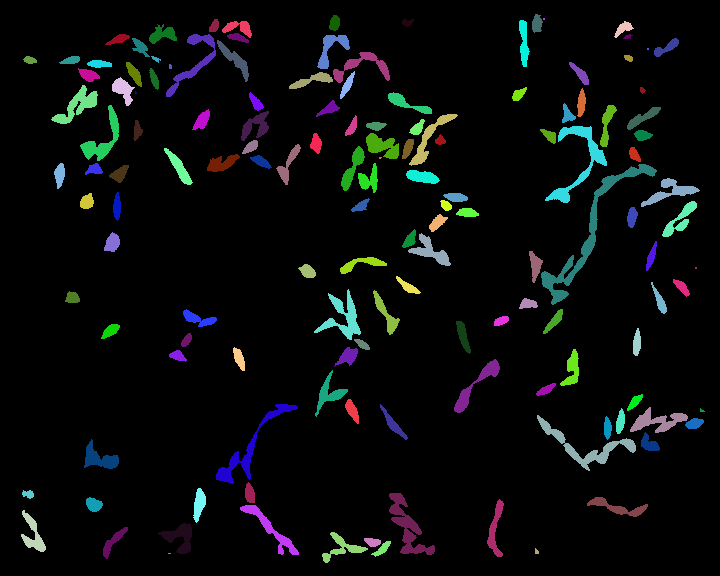

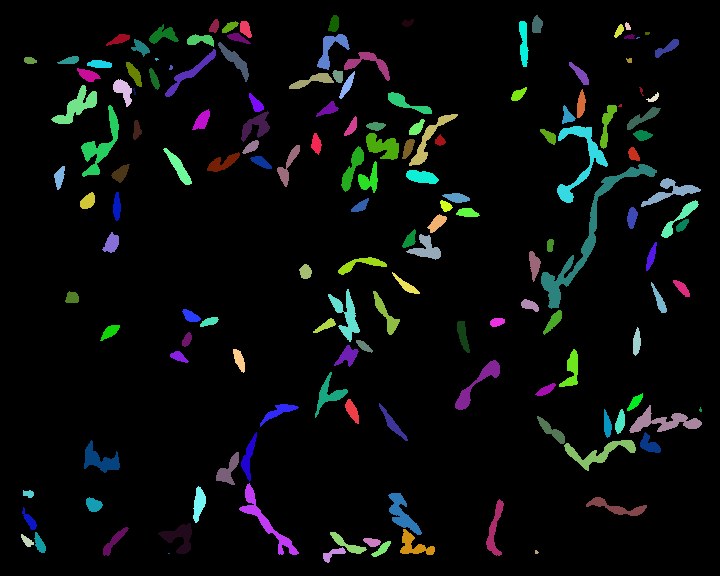

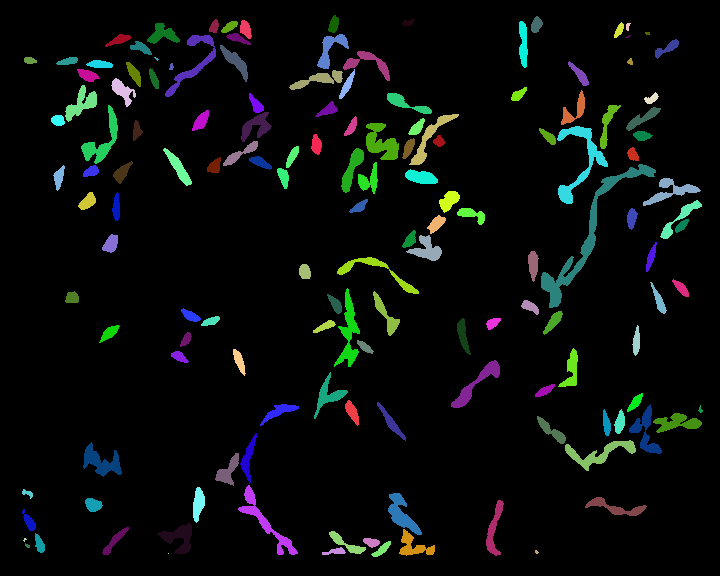

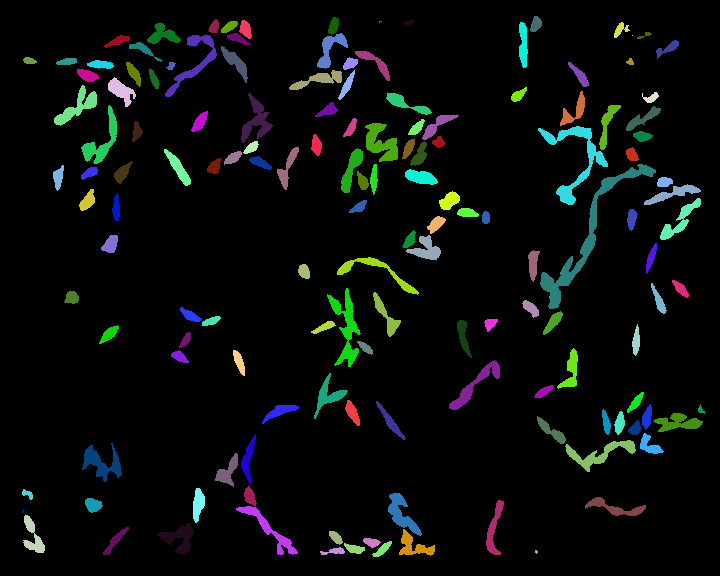

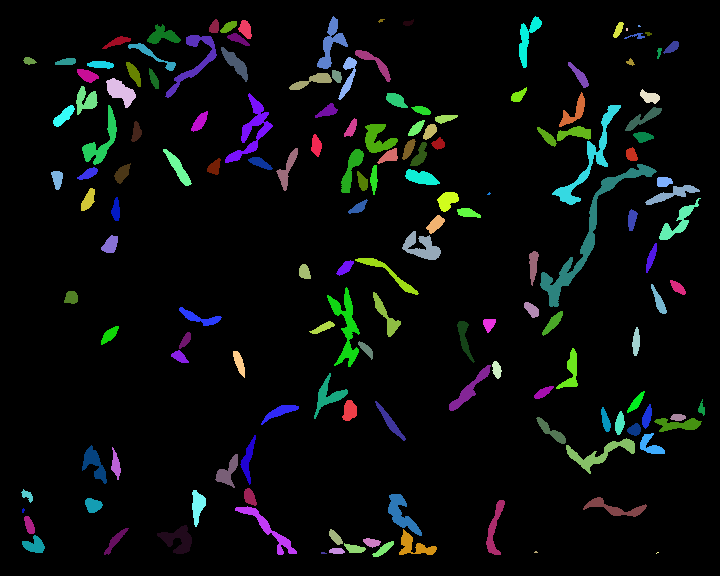

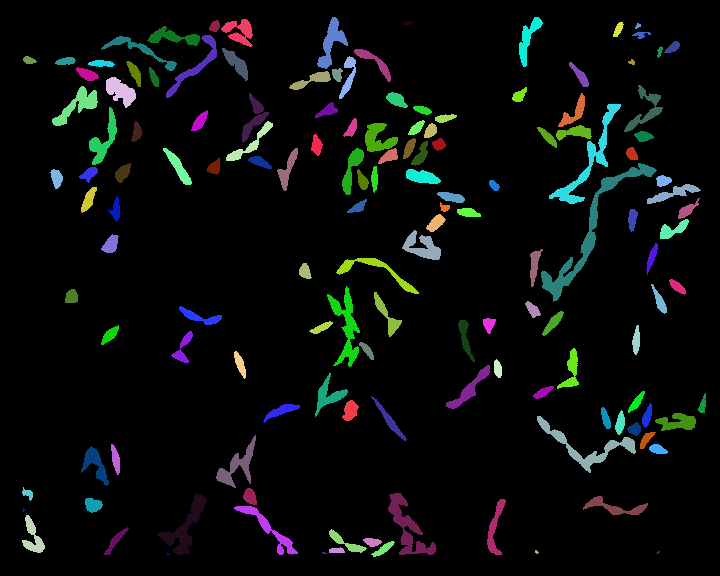

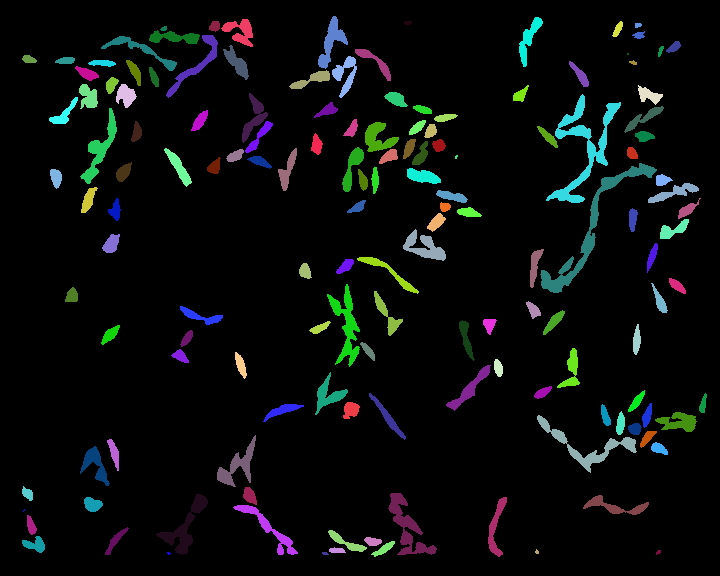

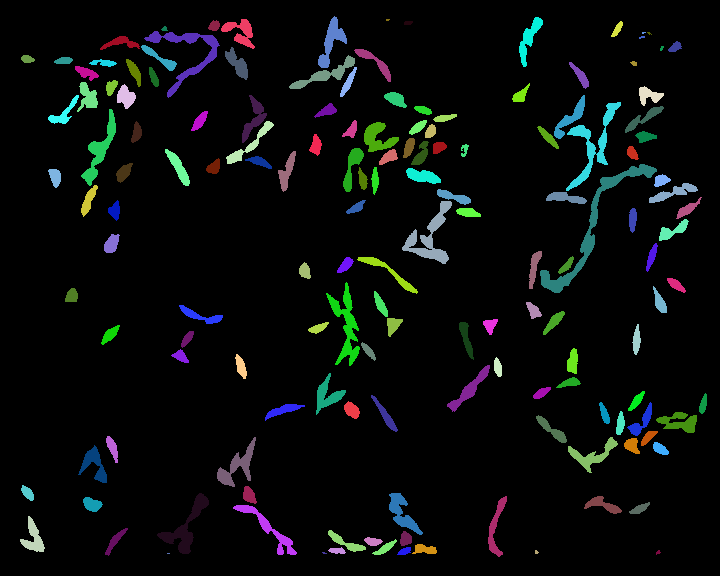

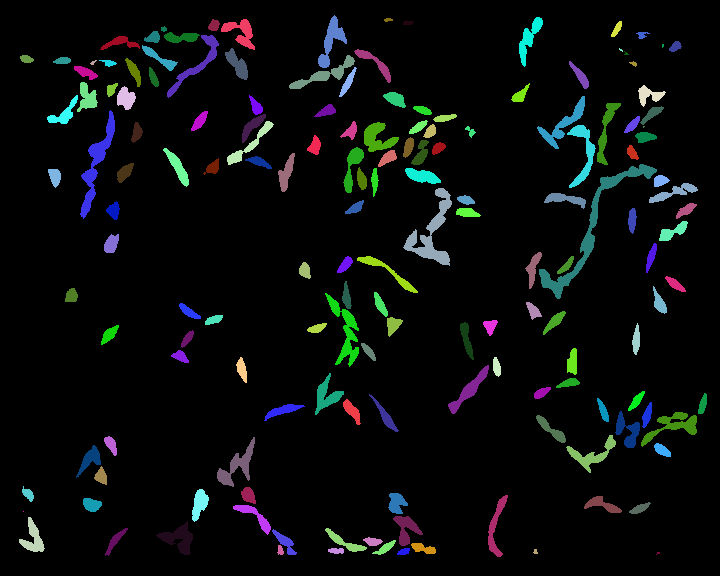

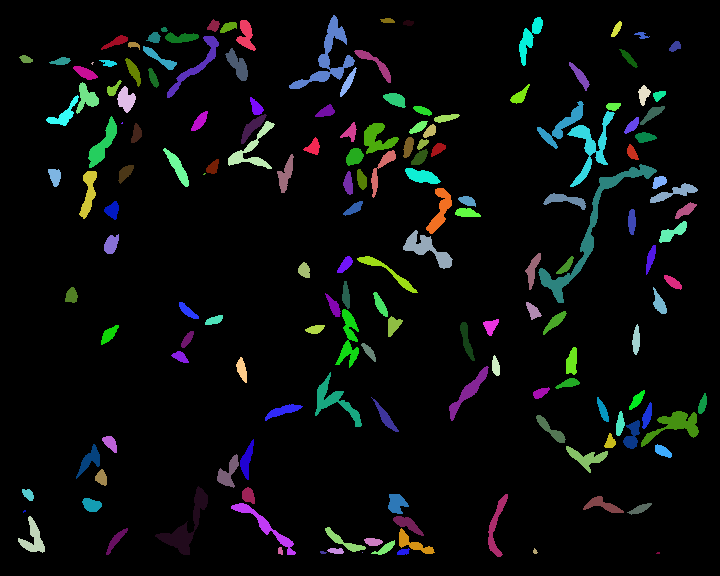

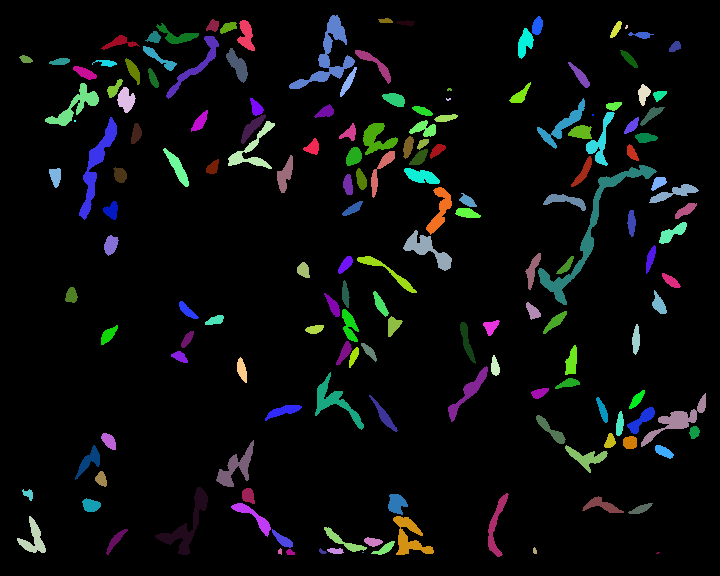

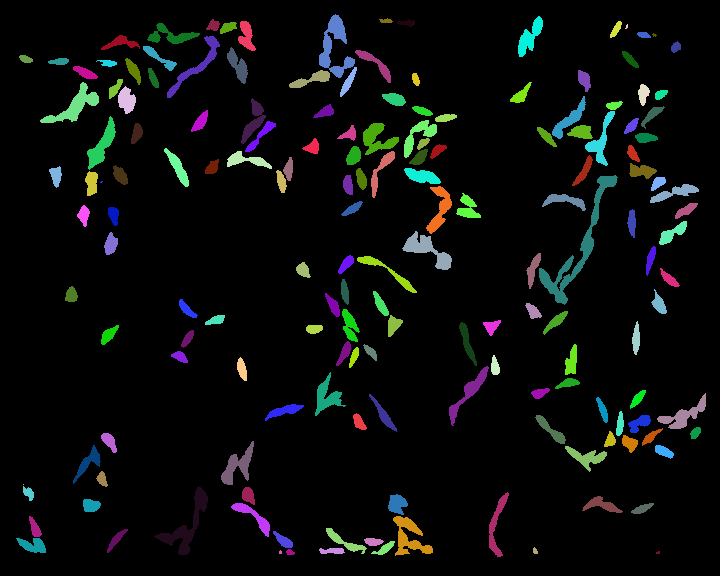

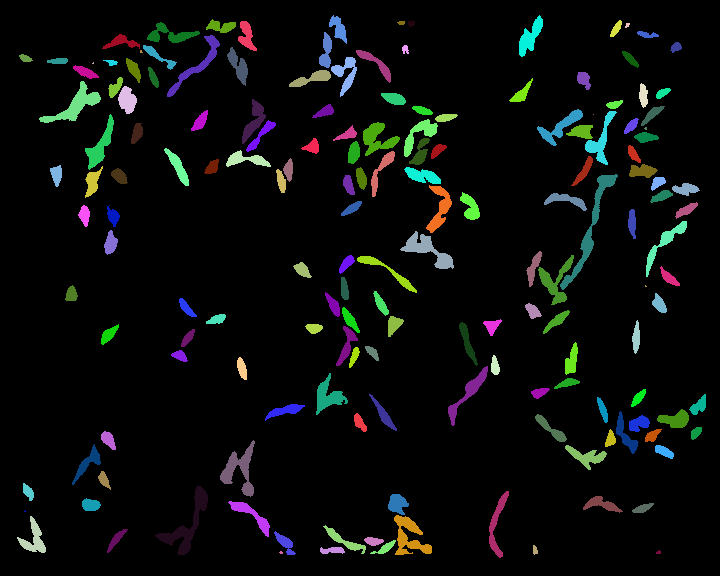

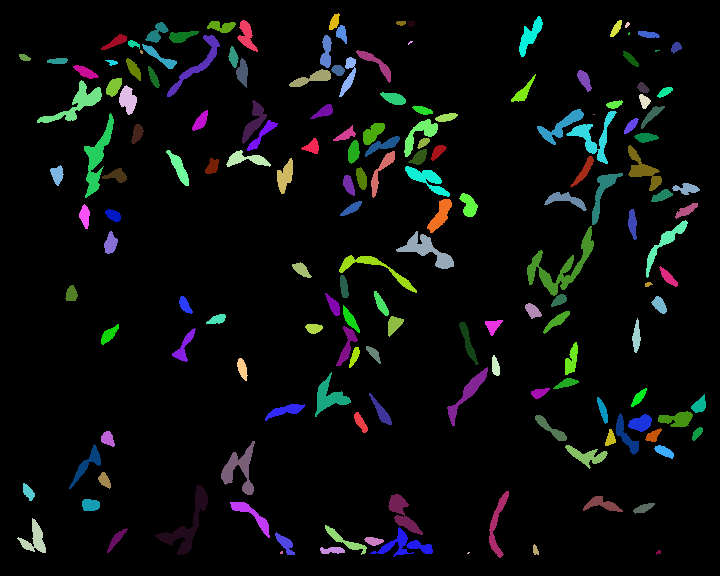

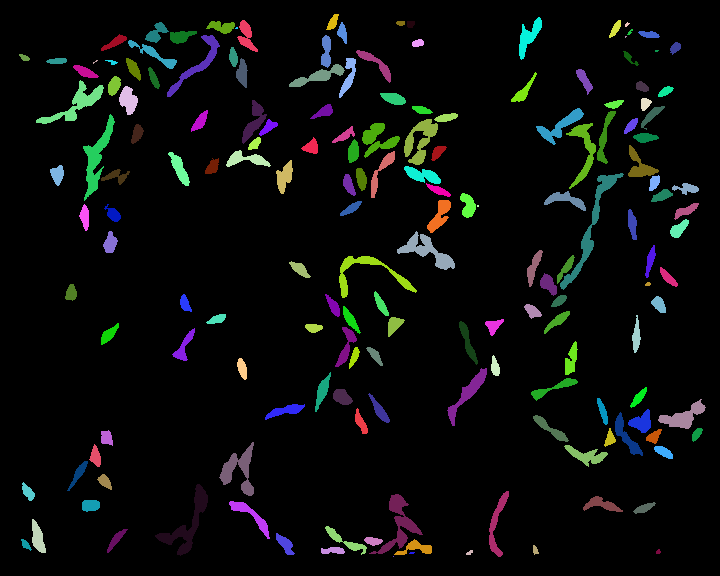

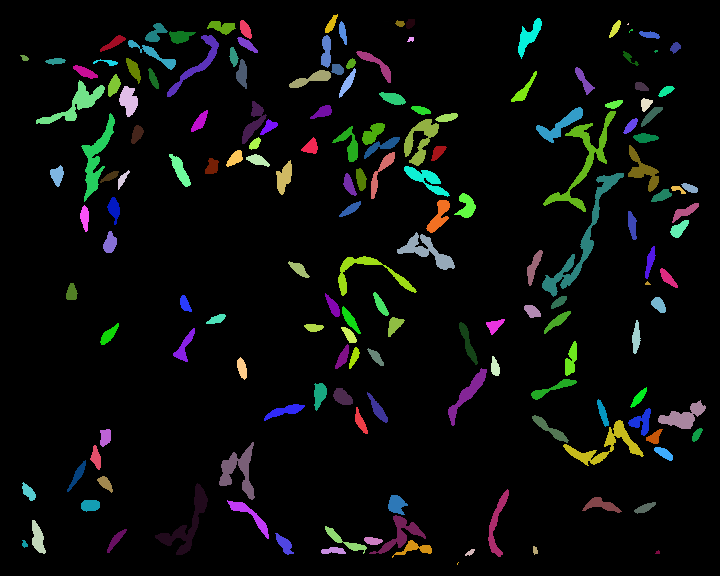

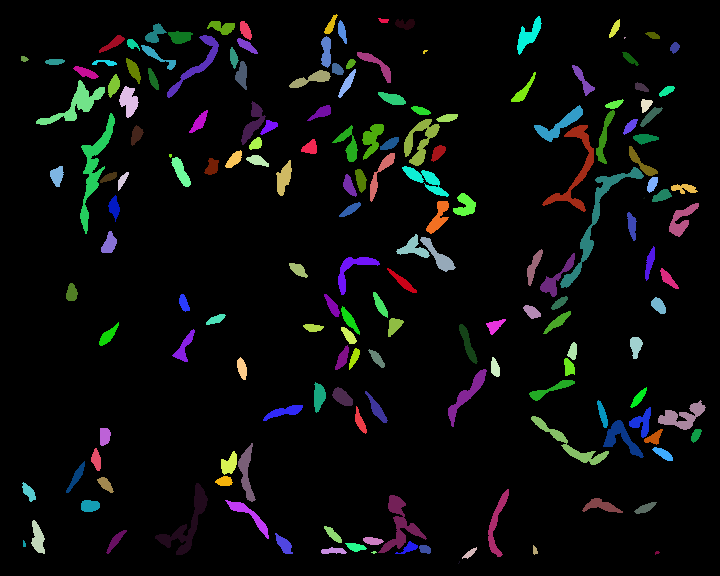

In [ ]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
from google.colab.patches import cv2_imshow

class CellTracker:
    def __init__(self, max_disappeared=5):
        self.nextCellID = 0
        self.cells = {}
        self.disappeared = {}
        self.colors = {}
        self.max_disappeared = max_disappeared

    def add_cell(self, centroid):
        self.cells[self.nextCellID] = centroid
        self.disappeared[self.nextCellID] = 0
        self.colors[self.nextCellID] = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
        self.nextCellID += 1

    def remove_cell(self, cellID):
        del self.cells[cellID]
        del self.disappeared[cellID]
        del self.colors[cellID]

    def update(self, centroids):
        if len(self.cells) == 0:
            for centroid in centroids:
                self.add_cell(centroid)
        else:
            cellIDs = list(self.cells.keys())
            prevCentroids = list(self.cells.values())

            D = dist.cdist(np.array(prevCentroids), np.array(centroids))
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()

            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue

                cellID = cellIDs[row]
                self.cells[cellID] = centroids[col]
                self.disappeared[cellID] = 0
                usedRows.add(row)
                usedCols.add(col)

            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            for row in unusedRows:
                cellID = cellIDs[row]
                self.disappeared[cellID] += 1

                if self.disappeared[cellID] > self.max_disappeared:
                    self.remove_cell(cellID)

            unusedCols = set(range(0, D.shape[1])).difference(usedCols)
            for col in unusedCols:
                self.add_cell(centroids[col])

        return self.cells

cell_tracker = CellTracker()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video_path = 'tracked_cells_video.mp4'
frame_height, frame_width = segmented_frames[0].shape[:2]
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (frame_width, frame_height))


output_frames = []
for frame in segmented_frames:
    contours, _ = cv2.findContours(frame.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(f"Number of contours detected: {len(contours)}")

    centroids = np.zeros((len(contours), 2), dtype="int")

    for (i, c) in enumerate(contours):
        M = cv2.moments(c)
        if M["m00"] > 0:
            centroids[i] = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        else:
            continue

    cells = cell_tracker.update(centroids)

    colored_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    for cellID, centroid in cells.items():
        color = cell_tracker.colors[cellID]
        for i, c in enumerate(contours):
            cX, cY = centroids[i]
            if cX == centroid[0] and cY == centroid[1]:
                cv2.drawContours(colored_frame, [c], -1, color, -1)
                break

    output_frames.append(colored_frame)
    out.write(colored_frame)

for out_frame in output_frames:
    cv2_imshow( out_frame)
    cv2.waitKey(0)
    print('\n')
cv2.destroyAllWindows()
out.release()